# Idea:

- Assume synchrotron peak comes from the same region as gammas and neutrinos.
- Obtain constraints on B, eta, and L_e from syn peak flux and freq
- Impose Hillas -> get p_gamma_max
- Impose n_p == n_e -> get L_p
- Fit data with different indices (around 2.0), gamma_min (1-10 for protons, 1-100 for electrons), eta_electron - B-field - L_e
- Test different values of L_p (impose Eddington), eta_proton > 10 (impose IceCube limits if possible)

# Todo:

- Implement diffusive escape in AM3
- Change B, Gamma_bulk evolution to ensure total energy is conserved and E_CR << E_B, E_kin (incl. radiative, potentially shocks downstream???)
-= Q: 1e-4 non-thermal particle fraction - necessary to maintain L_CR < L_k

# Done:

- Electrons do not escape up to ~ 30 pc, protons do but number is probably negligible?  
- Assume diff escape, Kolmogorov for E_max
- Plasma density == thermal. This rho goes into magnetization and t_acc (assuming L_CR negligible, as it should be) --- Gamma_bulk??
- Thermal must be smaller than observed column density, no toher constraint
- 1% of particvle number from thermal into non-thermal protons and electrons
- Check acceleration efficiency scaling (e.g. Rieger+2007)                                          
- Check gamma_min and effect on N_p^total vs N_e^total (gamma_min_e can be 500 e.g. )
- Check if it's possible to increase alpha to 1.7 in terms of gammas and neutrinos (and effect on N_p vs N_e). This comes from stochastic.

In [5]:
f"{0.3*1e9*1e9 / (40.8 * 20) * 20 * 0.05:.2e}"

'3.68e+14'

In [4]:
import os
import sys
import time
import numpy as np
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.constants import codata2010 as const
from astropy.constants import kpc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from iminuit import Minuit
np.seterr(all="ignore") # Ignore warnings
from scipy.optimize import fsolve


m_e_ev = (const.m_e * const.c ** 2).to(u.eV).value
m_p_ev = (const.m_p * const.c ** 2).to(u.eV).value
MPERG = (const.m_p * const.c ** 2).to(u.erg).value
import pickle



## LOAD CATALOG FOR PLOTTING
DATAPATH = "/Users/xrodrigu/analysis/sin/sin-v/data/"
with open(DATAPATH+"231106_sin_catalog.pkl", "rb") as f:
    CAT = pickle.load(f)

ev_to_hz = u.eV.to(u.J)/const.h.value

sys.path.append("/AM3/libpython")
import am3
am3 = am3.AM3()

torus_temperature = 500 * u.K
BLR_COVERING, TORUS_COVERING = 0.1, 0.3
cmtopc = u.cm.to(u.pc)
pctocm = 1./cmtopc

TIMESTEP = 0.1
SIMTIME = 3

<>:315: SyntaxWarning: invalid escape sequence '\s'
<>:346: SyntaxWarning: invalid escape sequence '\s'
<>:315: SyntaxWarning: invalid escape sequence '\s'
<>:346: SyntaxWarning: invalid escape sequence '\s'
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/2032702752.py:315: SyntaxWarning: invalid escape sequence '\s'
  dataTempl_BB = pd.read_csv(blue_bump_file, delimiter="\s+", names=["Frequency", "Flux"],  skiprows=1, header=None)
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/2032702752.py:346: SyntaxWarning: invalid escape sequence '\s'
  dataTempl_GE = pd.read_csv(ge_template_file, delimiter="\s+", names=["Frequency", "Luminosity"],  skiprows=1, header=None)


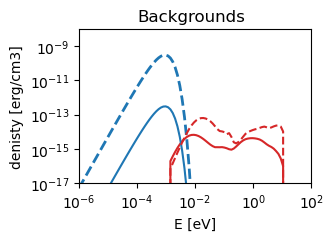

init. AM3 kernels:
AM3 has the following switches (at step: 0)
estimate maximum energies: 0
parse sed components: 1
escape: 1
expansion: 0
adiabatic: 1
synchrotron:
  e+/-: 1  (em..: 1, cool.: 1)
  protons:1  (em..: 1, cool.: 1)
  pions:0  (em..: 1, cool.: 1)
  muons:0  (em..: 1, cool.: 1)
  syn-self-abs.:1
  e+/- quantum-syn.:0
inv. Compton:
  e+/-: 1  (em.. : 1, cool.: 1 (continuous))
  photon loss due to upscattering: 0
  protons:1  (em.. (step approx.): 1, no cooling)
  pions:0  (em.. (step approx.): 1, cont. cool.: 1)
  muons:0  (em.. (step approx.): 1, cont. cool.: 1)
pair prod. (gamma+gamma->e+e)1  (photon loss.: 1, e+/- source (feedback): 1(opt. 14-bin kernel))
'hadronic' processes (below): 1
 Pion decay: 1 Muon decay:1)
proton Bethe-Heitler: 1  (em..: 1, cool.: 1)
proton photo-pion: 1  (em..: 1, cool.: 1, photon loss: 1)
proton p-p: 1  (em..: 1 , cool.: 1)

AM3 params (comoving):
escape_timescale: 1e+06 s
  with fractions: (protons: 1, neutrons: 1, pions: 1, muons: 1, neutrino

In [5]:

os.environ["GAMMAPY_DATA"] = "/Users/xrodrigu/analysis/sin/sin-v/data"
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    Models,
    PowerLawSpectralModel,

    SkyModel,
)
dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=0.)


bestfitpars = {}
with open(f"./best_fits.dat", "r") as f:
    results = f.readlines()
with open(f"./best_fits.dat", "r") as f:
    allresults = f.read()


for s in CAT:    
            
    if s not in allresults:
        continue
    solution = [[float(x) for x in r.split()[1:]] for r in results if s in r][0]

    bestfitpars[s] = solution



    mycolors = np.array([np.array([230,159,  0.]),
                     np.array([ 86,180,233.]),
                     np.array([  0,158,115.]),
                     np.array([240,228, 66.]),
                     np.array([  0,114,178.]),
                     np.array([213, 94,  0.]),
                     np.array([201,121,176.])])
mycolors *= 1./255

# ##################
# # LOW STATE
PARAMS_LEP = {}
PARAMS_LEP['0649_3139'] = {'r1' : 16.499169771399618,      
                            'b1' : -1.3601795636247869,
                            'egmax1' : 5.424702447750383,
                            'ealpha1' : 1.8214913065553737,
                            'elum1' : 41.47992893877567,
                            'lor1' : 1.4999999999969613,
                            'egmin1' : 2.7938065131304564
                            }
PARAMS = {'sourcename': '4FGLJ0649.5-3139', 
          'rblob':1.2e+16,
          'magfield':0.1e+00,
          'egammamin':1,
          'egammamax':2.e+05, 
          'eindex':1.5,
          'elum':1.5e+41,
          'lorentz':18.e+00,
          'rdissratio':10, ###
          'pgammamin':1e2,
          'pgammamax':1e6, 
          'pindex':1.0,
          'plum':4e+44*0,
          'z':0.7,
          'disk_lum':2.95e+44 / 2,
          'masquerading':'M'}

source = CAT[PARAMS['sourcename']]

am3.update_energy_grid(1e-9,1e9,1e21) # set Emin to 1e-9 !





def PlanckDistribution(earr, temperature, lum):
    '''
    Thermal Distribution (unnormalized)

    return: E^2dN/dE [a.u.]
    par earr (array): photon energy [eV]
    par temperature [K]
    par lum: total luminosity [erg/s]
    '''
    lgr = earr / temperature / const.k_B.to(u.eV/u.K)
    exparr = np.exp(lgr) - 1
    ednde = earr ** 4 / exparr
    integ = np.trapz(ednde / earr, earr)
    return ednde * lum / integ


def Schwarzschild(m_bh):
    '''Schwarzschild radius [cm]
    
    m_bh: black hole mass [m_solar]
    '''
    rad = (2 * const.G * m_bh * 1.989e30*u.kg 
           / const.c ** 2)
    return rad.to(u.cm)


def DiskTemperature(rad, lumdisk, m_bh, eta=0.08):
    '''Radius-dependent disk temperature [K]
    '''
    sb = const.sigma_sb.to(u.erg/u.s/
                           u.K**4/u.cm**2)
    rsch = Schwarzschild(m_bh)
    
    term1 = 3 * rsch * lumdisk / (16 * np.pi * eta 
                                  * sb * rad ** 3)
    term2 = 1 - (3 * rsch / rad) ** 0.5
    return (term1 * term2) ** 0.25
 

def ShakuraFlux(earr, lumdisk, m_bh, thetaobs=3.0, eta=0.08):
    '''Disk spectral flux in observer's frame [erg/cm2/s]
    
    earr (array): photon energies [eV]
    lumdisk: [erg/s]
    m_bh: black hole mass / m_solar
    thetaobs: angle btw. LOS and disk rotation axis (deg)
    '''
    kB = const.k_B.to(u.eV/u.K)
    c0 = const.c.cgs
    hplanck = const.h.to(u.eV*u.s)
#     dlum = cosmo.luminosity_distance(z).to(u.cm)
    rsch = Schwarzschild(m_bh)
    rin = 3 * rsch
    rout = 300 * rsch
    radarr = np.linspace(rin, rout, 50)
    
    frac = (4 * np.pi) ** 2 * hplanck * np.cos(thetaobs*np.pi/180) / c0 ** 2
    nuarr = earr / hplanck       # convert x-axis to obs frame
    en2d = earr[:,np.newaxis]    # convert x-axis to obs frame
    rad2d = radarr[np.newaxis,:]
    temp2d = DiskTemperature(rad2d,lumdisk,m_bh,eta) # K
    
    integrand = rad2d / (np.exp(en2d/temp2d/kB) - 1)
    integral = np.trapz(integrand, radarr, axis=1)
    Fnu = (nuarr ** 3 * frac * integral).to(u.erg)
    return nuarr * Fnu

def BroadLine(earr, center, width, lum):
    '''
    Broad line spectrum, normalized to `lum` 

    return: E^2dN/dE [a.u.]
    par earr (array): photon energies (eV)
    par center: line energy [eV]
    par width: line width (eV)
    par lum: line luminosity [erg/s]
    '''
    ednde = np.exp(-0.5 
                   * (earr - center) ** 2 
                   / width ** 2
                  )
#     ednde[ednde < 1e-100] = 0.
    integ = np.trapz(ednde/earr, earr)
    ednde *= lum / integ
    return ednde

def get_BLR_density_scaling(R_zone, R_diss, lorentz):
    '''Scaling of the photon density seen in the jet frame 
    with the dissipation radius, according to Eq. 20 of 
    Ghisellini+Tavecchio 0902.0793
    '''

    def scaling_for_large_R_diss(R_diss, R_zone, lorentz):
        beta = (1 - 1. / lorentz ** 2) ** 0.5
        mu1 = (1 + (R_zone / R_diss) ** 2) ** -.5
        mu2 = (1 - (R_zone / R_diss) ** 2) ** .5
        f_mu = (2 * (1 - beta * mu1) ** 3
                - (1 - beta * mu2) ** 3
                - (1 - beta) ** 3)
        return f_mu / 3. / beta

    f0 = 17. / 12
    
    if R_diss <= R_zone:
        scaling = f0
        
    elif R_diss >= 3 * R_zone:
        scaling = scaling_for_large_R_diss(
            R_diss,
            R_zone,
            lorentz)
        
    elif R_zone < R_diss < 3 * R_zone:
        # Power-law interpolation
        f_3R = scaling_for_large_R_diss(
            3 * R_zone, 
            R_zone,
            lorentz
        )
        scaling = 10 **(
            (np.log10(f_3R) - np.log10(f0))
            / (np.log10(3 * R_zone) - np.log10(R_zone))
            * (np.log10(R_diss) - np.log10(R_zone))
        )
        
    return scaling
     
def tangential_angle(R_BLR, R_diss):
    '''Calculate the characteristic angle of the radiaiton,
        which is the tangential angle. This is where the dominant
        contribution comes from because it has the highest doppler
        boost, as well as for geometric reasons.
    '''
    csi = np.arcsin(R_BLR/R_diss)
    return csi

def calc_doppler(lorentz, R_BLR, R_diss):
    '''Calculate relative Doppler factor between blob and BLR.
        The blob has bulk factor `lorentz` and distance to the black hole 
        given by `R_diss` [cm]. The BLR has radius `R_BLR` [cm].
    '''
    if R_diss <= R_BLR:
        return lorentz
         
    csi = tangential_angle(R_BLR, R_diss)
    beta = (1 - 1. / lorentz ** 2) ** 0.5
    doppler = lorentz * (1 - beta * np.cos(csi))
    return doppler

def doppler_factor(theta_obs, Gamma):

    beta = np.sqrt(1 - 1 / Gamma ** 2)
    delta = 1 / (Gamma * (1 - beta * np.cos(theta_obs)))
    return delta

def convert_lum_to_density_in_jet(R_diss, lorentz, R_BLR):
        ''' Convert external field luminosity in the rest frame of the 
        black hole in [erg/s] into energy density in the comoving frame 
        of the jet blob in [GeV / cm^3]. R_BLR can represent the BLR radius
        or the dust torus radius. 

        return: conversion factor [GeV erg^-1 s cm^-3]
        '''      
        if R_diss < 1e-100: R_diss += 1e-100 
        if lorentz < 1e-100: lorentz += 1e-100 
        if R_BLR < 1e-100: R_BLR += 1e-100
            
        doppler_fact = calc_doppler(lorentz, R_BLR, R_diss)
        
        f1 = (lorentz ** 2 
                / (4.
                    * np.pi 
                    * R_BLR ** 2 
                    * const.c.cgs.value)
                * u.erg.to('GeV'))
                
        f2 = get_BLR_density_scaling(R_BLR, R_diss, lorentz)
        factor =  f1 * f2 
        
        return factor

def convert_lum_to_density_in_jet_full(R_diss, lorentz, R_BLR):
        ''' Convert external field luminosity in the rest frame of the 
        black hole in [erg/s] into energy density in the comoving frame 
        of the jet blob in [GeV / cm^3]. R_BLR can represent the BLR radius
        or the dust torus radius. 

        return: conversion factor [GeV erg^-1 s cm^-3]
        '''      
        if R_diss < 1e-100: R_diss += 1e-100 
        if lorentz < 1e-100: lorentz += 1e-100 
        if R_BLR < 1e-100: R_BLR += 1e-100
            
        doppler_fact = calc_doppler(lorentz, R_BLR, R_diss)
        
        f1 = (doppler_fact ** 2 
                / (4.
                    * np.pi 
                    * R_BLR ** 2 
                    * const.c.cgs.value)
                * u.erg.to('GeV'))
                
        f2 = get_BLR_density_scaling(R_BLR, R_diss, lorentz)
        factor =  f1 * f2 
        
        return factor

def convert_torus_lum_to_density_in_jet(R_diss, lorentz, R_torus):
        ''' Convert external field luminosity in the rest frame of the 
        black hole in [erg/s] into energy density in the comoving frame 
        of the jet blob in [GeV / cm^3]. R_BLR can represent the BLR radius
        or the dust torus radius. 

        return: conversion factor [GeV erg^-1 s cm^-3]
        '''      
        if R_diss < 1e-100: R_diss += 1e-100 
        if lorentz < 1e-100: lorentz += 1e-100 
            
        csi = np.arctan(R_torus / R_diss) # i think
        beta = (1 - 1. / lorentz ** 2) ** 0.5
        doppler_fact = lorentz * (1 - beta * np.cos(csi))

        factor = (doppler_fact ** 2 
                / (4.
                    * np.pi 
                    * (R_torus ** 2 + R_diss ** 2) 
                    * const.c.cgs.value)
                * u.erg.to('GeV'))
        
        
        return factor

###################
## TEMPLATES
###################

def get_blue_bump(z, disklum, plot=0,threshold=0):
    
    blue_bump_file ='/Users/xrodrigu/analysis/sin/sin-v/data/templates/BlueBumpTemplNormalised_4py.txt'
    dataTempl_BB = pd.read_csv(blue_bump_file, delimiter="\s+", names=["Frequency", "Flux"],  skiprows=1, header=None)
    dataTempl_BB["FreqObserverframe"] = dataTempl_BB["Frequency"] / (1.+z)

    # Different definition: MAXIMUM
    scaling_factor = disklum / np.max(dataTempl_BB["Flux"]) #  
    dataTempl_BB["Flux5000"] = dataTempl_BB["Flux"] * scaling_factor
    if z <= 0.:
        print("[get_blue_bump]Error: z=0!")
        return
    distance = cosmo.luminosity_distance(z)*kpc*1e5
    nulnuat1p2e15 = 4.*np.pi*distance.value**2*scaling_factor*1.938
    # 1.e15 = 2500 A                                                                                                                                                       
    # 1.938 is the flux value at nu = 1.2e15 in the BlueBumpTemplNormalised_4py.txt file                                                                                   
    # 0.154 is the flux value at nu = 2.41E17 in the BlueBumpTemplNormalised_4py.txt file                                                                                  
    scalingXflux = 10.**((-0.137*np.log10(nulnuat1p2e15)+4.704+1.0)*2.605)/0.154
    ddUVOTTB = dataTempl_BB [dataTempl_BB["Frequency"] < 1.e16]
    ddXTB = dataTempl_BB [dataTempl_BB["Frequency"] > 1.e16]
    x, y = ddUVOTTB["FreqObserverframe"], ddUVOTTB["Flux5000"]
    y[x<threshold] *= 0
    if plot:
        plt.gca().errorbar(x, y, xerr=None, yerr=None, fmt='o', color = '#009900', markersize='1')
    
    return x, y, y * 0


def get_giant_elliptical(z, plot=0, **kwargs):
    label = kwargs['label'] if 'label' in kwargs else None
    
    distance =  cosmo.luminosity_distance(z)*kpc*1e5
    const = 4.*np.pi*distance.value**2
    ge_template_file ='/Users/xrodrigu/analysis/sin/sin-v/data/templates/GiantEllipticalTemplate_4py.txt'
    dataTempl_GE = pd.read_csv(ge_template_file, delimiter="\s+", names=["Frequency", "Luminosity"],  skiprows=1, header=None)
    dataTempl_GE["FreqObserverframe"] = dataTempl_GE["Frequency"] / (1.+z)
    dataTempl_GE["Flux"] = dataTempl_GE["Luminosity"] / const * 1.0
    x, y = dataTempl_GE["FreqObserverframe"],dataTempl_GE["Flux"]
    if plot:
        # plt.gca().errorbar(x, y, xerr=None, yerr=None, fmt='o', color = '#ff33cc', markersize='1', ls ='-')
        plt.loglog(x, y, color = '#ff33cc', ls ='-', label=label)
    return x, y, y * 0

def get_vou_sed(vou_sed_file, plot=0):
    data  = pd.read_csv(vou_sed_file,  delimiter="," , names=["Frequency", "Flux", "Flux_err", "MJD", "MJD_end", "IsDet", "Cat", "Reference"],  skiprows=1, header=None)

    data['xtype'] = data['Frequency']    

    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.gca().tick_params(axis='both', which='both', direction='in', length=5 , labelsize=18, top=True, right=True, labeltop=False, labelright=False)

    dda = data[data["Cat"].str.strip() != 'DEBL']
    debl = data[data["Cat"].str.strip() == 'DEBL']
    deros = data[(data["Cat"].str.strip()  == 'eROSITA-EDR') & (data["IsDet"] != 'UL')]
    dalma = data[data["Cat"].str.strip()   == 'ALMA']
    dneowise = data[data["Cat"].str.strip()   == 'NEOWISE']
    dsmarts = data[data["Cat"].str.strip() == 'SMARTS']
    dnustar = data[data["Cat"].str.strip() == 'NuBlazar']
    dxmm = data[(data["Cat"].str.strip()  == 'XMMSL2') | (data["Cat"].str.strip()  == '4XMM-DR11') | (data["Cat"].str.strip()  == '4XMM-DR13')]
    dswift = data[(data["Cat"].str.strip()  == 'SUFST')]
    dd  = dda[(dda["IsDet"] != 'UL') & (dda["Flux_err"] >= 0.) & ( ( (dda["Frequency"] > 1.4e13) | (dda["Frequency"] < 1.3e13) ) | ( ( (dda["Frequency"] > 1.3e13) & (dda["Frequency"] < 1.4e13) ) & (dda["Flux"] > 1.5e-12) ) ) ]
    dlimit = data[ (data["IsDet"] == 'UL') | (data["Flux_err"] >= data["Flux"]) ]
    x, y, yerr = dd["xtype"], dd["Flux"], dd["Flux_err"]
    
    if plot:
        plt.gca().errorbar(x, y, xerr=None, yerr=yerr, fmt='o',color = '#0066cc', markeredgecolor='black', markersize='5',zorder=8)
    return x, y, yerr


def plot_data_and_templates(sname, z, 
                            bbb_flux,
                            plot_bbbump=True, 
                            plot_giant_elliptical=True, 
                            plot_data=True, **kwargs):
    
    label = kwargs['ge_label'] if 'ge_label' in kwargs else None
    label = kwargs['ge_label'] if 'ge_label' in kwargs else None
    
    if plot_data:
        sed_file = f"/Users/xrodrigu/analysis/sin/sin-v/data/vou_data/sed_sin_{sname}.csv"
        sed_x,sed_y,sed_e = get_vou_sed(sed_file, plot=plot_data)
    
    if plot_giant_elliptical:
        ge_x,ge_y,ge_e = get_giant_elliptical(z, plot=plot_giant_elliptical,label=ge_label)
    if plot_bbbump:
        bb_x,bb_y,bb_e = get_blue_bump(z,bbb_flux, plot=plot_bbbump,label=bb_label)
    
    plt.loglog()

    ymin = min([1e-17, min(sed_y) / 3.])
    ymax = max([1e-11, max(sed_y) * 3.])
    plt.axis([1e7,1e33,ymin,ymax])
    plt.xlabel(r'${\rm Frequency}$ $\nu_{\rm observer~frame}{\rm [Hz]}$', fontsize=20 )
    plt.ylabel(r'$\nu$F$_{\nu}$ [erg cm$^{-2}$ s$^{-1}$]', fontsize=20)

    return sed_x, sed_y, sed_e

PLOT_ALL = False

def inject_and_run(verbose=0):
    #############################################
    ### Define accelerated electron spectrum
    #############################################
    elec_emin =  PARAMS['egammamin'] * (const.m_e * const.c ** 2).to(u.eV).value # eV
    elec_emax =  PARAMS['egammamax'] * (const.m_e * const.c ** 2).to(u.eV).value # eV
    eindex =     PARAMS['eindex']
    elum =       PARAMS['elum'] # erg/s
    R_diss = PARAMS['rdissratio'] * R_BLR
    
    lorentz = PARAMS['lorentz']
    disk_lum = PARAMS['disk_lum']
    
    egrid = am3.get_egrid_lep()
    epowerlaw = (egrid ** (2 - eindex) 
                    * (egrid >= elec_emin)
                    * np.exp(-egrid / elec_emax)
                )
    
    # EIND2 = 3.5
    # epowerlaw = (egrid ** (2 - eindex) 
    #                 * (egrid >= elec_emin)
    #                 * (egrid < elec_emax)
    #                 + (egrid ** (2 - EIND2))
    #                 * (egrid >= elec_emax)
    #                 * (elec_emax ** (EIND2 - eindex)) # ALTERNATIVE, BROKEN POWER-LAW
    #                 * (egrid < 1e13)
    #             )
    
    # plt.loglog(am3.get_egrid_lep(), epowerlaw * am3.get_egrid_lep())
    # plt.show()
    # epowerlaw[epowerlaw < 1e-100] = epowerlaw[epowerlaw < 1e-100] * 0 + 1e-100

    
    # Integrate spectrum in erg/s
    etrapz = np.trapz(epowerlaw / egrid, egrid)
    
    # Normalize it to the desired electron lumiosity
    enormalized = epowerlaw * elum / etrapz # erg/s
    
    # Convert it to an energy density injection rate
    volume = 4/3 * np.pi * (am3.get_escape_timescale() * const.c.cgs.value) ** 3
    enormalized /= volume # erg/cm3/s
    
    # And finally to a particle density injection rate
    enormalized /= egrid * u.eV.to(u.erg) # cm-3.s-1
    
    #############################################
    ### Define accelerated proton spectrum
    #############################################
    
    proton_emin =  PARAMS['pgammamin'] * (const.m_p * const.c ** 2).to(u.eV).value # eV 
    proton_emax =  PARAMS['pgammamax'] * (const.m_p * const.c ** 2).to(u.eV).value # eV
    pindex =     PARAMS['pindex']
    plum =       PARAMS['plum'] # erg/s
    
    pgrid = am3.get_egrid_had()
    ppowerlaw = (pgrid ** (2 - pindex)
                    * (pgrid >= proton_emin)
                    * np.exp(- pgrid / proton_emax)
                )

    # Integrate spectrum in erg/s
    ptrapz = np.trapz(ppowerlaw / pgrid, pgrid)
          
    # Normalize it to the desired proton lumiosity
    pnormalized = ppowerlaw * plum / ptrapz # erg/s
               
    # Convert it to an energy density injection rate
    volume = 4/3 * np.pi * (am3.get_escape_timescale() * const.c.cgs.value) ** 3
    pnormalized /= volume # erg/cm3/s
        
    # And finally to a particle density injection rate
    pnormalized /= pgrid * u.eV.to(u.erg) # cm-3.s-1
    
    
    #############################################
    ### Define external photon spectrum
    #############################################
    
    # Define BLR and torus parameters


    blr_doppler = calc_doppler(lorentz, R_BLR, R_diss)
    torus_doppler = calc_doppler(lorentz,R_TORUS,R_diss)
    
    # AM3 photon grid
    egrid_jetframe = am3.get_egrid_photons() * u.eV 
    
    # Set up array for adding up external fields
    external_photons = np.zeros(egrid_jetframe.size) * u.GeV / u.cm**3
    
    # Scattered thermal disk emission
    templ_diskx, templ_disky = np.loadtxt('/Users/xrodrigu/analysis/sin/sin-v/data/disk_continuum_template.dat', unpack=1, delimiter=',')
    disky = 10 ** np.interp(np.log10(egrid_jetframe.value / blr_doppler),
                            np.log10(templ_diskx),
                            np.log10(templ_disky)) * (disk_lum / 1e45) * u.erg / u.s
    # Broad line emission
    hybl = BroadLine(egrid_jetframe / blr_doppler, 
                        10.2*u.eV, 10.2*u.eV/20, 
                        disk_lum * u.erg / u.s * BLR_COVERING) # H Ly alpha [erg/s]
    hebl = BroadLine(egrid_jetframe / blr_doppler, 
                        40.8*u.eV, 40.8*u.eV/20, 
                        disk_lum * u.erg / u.s * BLR_COVERING * 0.5) # He Ly alpha [erg/s]
    # Convert BLR components to jet frame

    blr_to_jet = convert_lum_to_density_in_jet(R_diss,lorentz,R_BLR) # erg/s -> GeV/cm3 
    blr_to_jet *= u.GeV / u.cm ** 3 / (u.erg / u.s) # give it units

    external_photons += (disky * 0.01 +
                         hybl+  
                         hebl
                         ) * blr_to_jet #* 1e-10 
    
    # Dust torus
    torusy = PlanckDistribution(egrid_jetframe / torus_doppler,
                                torus_temperature,
                                disk_lum * u.erg / u.s * TORUS_COVERING) # [erg/s]  
    # Convert torus emission to jet frame
    tor_to_jet = convert_torus_lum_to_density_in_jet(R_diss,lorentz,R_TORUS) # erg/s -> GeV/cm3 
    tor_to_jet *= u.GeV / u.cm**3 / (u.erg/u.s)  # give it units

    # Add torus to BLR components 
    external_photons += torusy * tor_to_jet 
    
    # Convert summed up components from energy density to photon density in jet frame
    external_photonspectrum = (external_photons / egrid_jetframe).to(u.cm ** -3).value # cm-3
    
    # Convert photon density to density ijnjection rate
    external_photonspectrum /= am3.get_escape_timescale() # cm-3.s-1


    #######################
    ### INJECT PARTICLES
    #######################
    
    # Reset all particle arrays to zero
    am3.clear_particle_densities()
    am3.evolve_step()
    
    # Inject cosmic rays and external photons in the simulation
    if verbose: print("Injecting electrons and protons...")
    
    am3.set_injection_rate_electrons(enormalized)
    am3.set_injection_rate_protons(pnormalized)

    if verbose: print("Injecting external photons...")
    am3.set_injection_rate_photons(external_photonspectrum)
    am3.set_current_densities_photons(external_photonspectrum * am3.get_escape_timescale())

    #######################
    ### RUN SIMULATION
    #######################
    
    if verbose: print("Evolving solver to the steady state...")

    if PLOT_ALL: ftemp = plt.figure()

    escaped = {'e' : am3.get_egrid_lep() * 0,
                'p' : am3.get_egrid_had() * 0,
                'n' : am3.get_egrid_had() * 0,
                'g' : am3.get_egrid_photons() * 0,
                'g_had' : am3.get_egrid_photons() * 0,
                'g_lep' : am3.get_egrid_photons() * 0,
                }

    esc_frac_electrons = np.minimum(am3.get_egrid_lep()*0+1., am3.get_escape_timescale() / am3.get_t_pair_escape())
    esc_frac_protons = np.minimum(am3.get_egrid_had()*0+1., am3.get_escape_timescale() / am3.get_t_proton_escape())

    time = 0.
    # INJ_ON = 1
    while time < SIMTIME * am3.get_escape_timescale():  # Run up to 3x the light-crossing time a

        # if INJ_ON:
        #     if time > am3.get_escape_timescale():
        #         am3.set_injection_rate_electrons(am3.get_egrid_lep()*0)
        #         am3.set_injection_rate_protons(am3.get_egrid_had()*0)
        #         INJ_ON = 0
                
        am3.evolve_step()                  # Evolve solver
        time += am3.get_solver_time_step() # Count time

        # escaped['e']     += am3.get_egrid_lep() * u.eV.to(u.erg) * am3.get_electrons() * 4 * np.pi * (am3.get_escape_timescale()*const.c.cgs.value) ** 2 * const.c.cgs.value * am3.get_solver_time_step() * esc_frac_electrons
        # escaped['p']     += am3.get_egrid_had() * u.eV.to(u.erg) * am3.get_protons() * 4 * np.pi * (am3.get_escape_timescale()*const.c.cgs.value) ** 2 * const.c.cgs.value * am3.get_solver_time_step() * esc_frac_protons
        # escaped['n']     += am3.get_egrid_had() * u.eV.to(u.erg) * am3.get_neutrons() * 4 * np.pi * (am3.get_escape_timescale()*const.c.cgs.value) ** 2 * const.c.cgs.value * am3.get_solver_time_step()
        # escaped['g']     += am3.get_egrid_photons() * u.eV.to(u.erg) * am3.get_photons_except_injected() * 4 * np.pi * (am3.get_escape_timescale()*const.c.cgs.value) ** 2 * const.c.cgs.value * am3.get_solver_time_step() 
        # escaped['g_lep'] += am3.get_egrid_photons() * u.eV.to(u.erg) * am3.get_photons_injected_electrons_syn_compton() * 4 * np.pi * (am3.get_escape_timescale()*const.c.cgs.value) ** 2 * const.c.cgs.value * am3.get_solver_time_step() 
        # escaped['g_had'] += am3.get_egrid_photons() * u.eV.to(u.erg) * (am3.get_photons_annihilation_pairs_syn_compton() +
        #                     am3.get_photons_photo_pion_pairs_syn_compton() +
        #                     am3.get_photons_pi0_decay() +
        #                     am3.get_photons_protons_syn_compton()) * 4 * np.pi * (am3.get_escape_timescale()*const.c.cgs.value) ** 2 * const.c.cgs.value * am3.get_solver_time_step()         

        if PLOT_ALL:
            plt.loglog(am3.get_egrid_lep(), am3.get_electrons() * am3.get_egrid_lep())
    
    if PLOT_ALL: 
        plt.axis([1e5,1e10,1e-50,1e-40])
        plt.show()
    return escaped

def get_etotal_from_number(n, alpha, emin, emax):
    
    egrid = np.logspace(np.log10(emin), # eV
                        np.log10(emax),
                        100)
    epowerlaw = (egrid ** (2 - alpha) 
                    * (egrid >= emin)
                    * np.exp(- egrid / emax)
                )
    ntrapz = np.trapz(epowerlaw / egrid ** 2, egrid)    
    normalized = epowerlaw * n / ntrapz 
    etotal = np.trapz(epowerlaw / egrid, egrid) * u.eV.to(u.erg)
    
    return etotal # erg


################################################################################
#########   ##########   ##########   EBL   ##########   ##########   ##########     
################################################################################

sys.path.append('/Users/xrodrigu/analysis/sin/sin-v/data/CRPropa3-data/')
import photonField

def get_ebl(e,z,model='Sal'):
    '''
    Energy in eV; 
    Return spectrum in cm-3
    '''
    if z > 3:
        z = 3
    
    dom = photonField.EBL_Saldana21()
    if model == 'Dom':
        dom = photonField.EBL_Dominguez11()
    elif model == 'Fra':
        dom = photonField.EBL_Franceschini08()
    elif model == 'Gil':
        dom = photonField.EBL_Gilmore12()
    elif model == 'Ste':
        dom = photonField.EBL_Stecker16()
    elif model != 'Sal':
        print(f"[get_ebl]WARNING: EBL model {model} not recognized. Using Saldana-Lopez 2021.")

    spec = dom.getDensity(e * u.eV.to(u.J),z=z) * (1./u.m**3/u.J).to(1./u.cm**3/u.eV).value * (1 + z) ** 3
    return spec * e

def get_cmb(e, z):
    '''
    Energy in eV; 
    Return spectrum in cm-3ƒ
    '''
    cmb = photonField.CMB()
    spec = cmb.getDensity(e * u.eV.to(u.J),0.0) * (1./u.m**3/u.J).to(1./u.cm**3/u.eV, z).value * (1 + z) ** 3
    return spec * e

_ =plt.figure(figsize=(3,2))

ex = np.logspace(-6,2,100)

plt.loglog(ex, ex * u.eV.to(u.erg) * get_ebl(ex, 0.0),c='tab:red')
plt.loglog(ex, ex * u.eV.to(u.erg) * get_cmb(ex, 0.0), c='tab:blue')

plt.loglog(ex, ex * u.eV.to(u.erg) * get_cmb(ex, 9.0), ls='--', c='tab:blue', lw=2)

plt.loglog(ex, ex * u.eV.to(u.erg) * get_ebl(ex, 9.0), ls='--',c='tab:red')

plt.axis([1e-6,1e2,1e-17,1e-8])
plt.suptitle("Backgrounds")
plt.xlabel("E [eV]")
plt.ylabel("denisty [erg/cm3]")
plt.show()

# def create_interpolated_EBLmodel(ebl_filename):
#     """ Creates an interpolated version of the ebl model.
#         Based on the data file found in CRPropa3-data/tables/EBL_Gilmore_2012/eblflux_fixed.dat
#     """
#         import astropy.units as u
#         from astropy.constants import hbar, c
#         from scipy.interpolate import RectBivariateSpline

#         zlist = np.array([0.0, 0.015, 0.025, 0.044, 0.05, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0])
#         eblg = np.loadtxt(ebl_filename)

#         elist = (2*np.pi*hbar*c / (eblg[:, 0] * 1e-10 * u.m)).to('eV').value[::-1] # energies 
#         density_grid = (4*np.pi / c * eblg[:, 0][:, np.newaxis] * eblg[:, 1:] * u.erg / u.s / u.cm**2 / (2*np.pi*hbar*c / (eblg[:, 0][:, np.newaxis] * 1e-10 * u.m))**2).to('1/(eV*m^3)').value[::-1, :]

#         eblg_interp = RectBivariateSpline(elist, zlist, density_grid / (1 + zlist[np.newaxis, :])**3, s=0)
        
#         return eblg_interp

def propagate(egrid, emitted_spectrum, z_source=.3, igmf_gauss=1e-16, include_cascade=True, delta_t=0.01,local_distance_pc=0):
    # return [egrid, emitted_spectrum, emitted_spectrum, emitted_spectrum] 
    from astropy.cosmology import z_at_value
    
    saved_props = [am3.get_escape_timescale()*1.0, am3.get_mag_field() * 1.0]
    am3.clear_particle_densities()
    am3.evolve_step()
    am3.clear_particle_densities()

    # unirad = 46.5e9 * u.lightyear.to(u.cm)

    proprad = cosmo.lookback_distance(z_source).cgs.value # cm
    proptime = cosmo.lookback_time(z_source)
    
    # For local sources, use distance
    if z_source == 0:
        proprad = local_distance_pc * u.pc.to(u.cm)
        proptime = proprad / const.c.cgs.value * u.s

    print(f"Propagating photons: {proptime:.1e} ({proprad*u.cm.to(u.Mpc):.1e} Mpc)")

    am3.set_escape_timescale(proptime.to(u.s).value)
    am3.set_solver_time_step(delta_t * am3.get_escape_timescale())

    am3.set_powerlaw_injection_parameters_electrons(1e10, 0.0, 100, 100, 1e6, 2, 2, 1)
    am3.set_powerlaw_injection_parameters_protons(1e10, 0.0, 100, 100, 1e6, 2, 2, 1)
    am3.set_injection_rate_photons(am3.get_egrid_photons() * 0)
    
    am3.set_mag_field(igmf_gauss)

    am3.set_escape_fraction_pairs(1. + 1e10 * (not include_cascade))

    time = am3.get_solver_time_step()
    counter = 0
    last_z = z_source
    ecut = 1e1
    totalzfac = 1.
    while time < am3.get_escape_timescale()*1.00001:
        
        lbtime = proptime - (time * u.s.to(u.Gyr) * u.Gyr)
        z = z_at_value(cosmo.lookback_time, lbtime, zmin=-1e-2,zmax=z_source*1.1).value
        zfac = (1+z)/(1+last_z)
        totalzfac *= zfac
        zround = round(z, 1)
        # zlist = np.array([0.0, 0.015, 0.025, 0.044, 0.05, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0])
        # zround = zlist[np.abs(zlist - z).argmin()]
        bckg = get_ebl(am3.get_egrid_photons(), zround, model='Sal') + get_cmb(am3.get_egrid_photons(), zround) # approximation (check posibilities)

        source_emission = np.interp(am3.get_egrid_photons(), am3.get_egrid_photons() * zfac, am3.get_photons()) / (zfac) ** 0.9
        if counter == 0:
            source_emission = np.interp(am3.get_egrid_photons(), 
                             egrid,
                             emitted_spectrum / const.c.cgs.value)    # erg/cm2/s -> erg/cm-3
        
            source_emission /= (am3.get_egrid_photons()*u.eV.to(u.erg)) # erg/cm3   -> cm-3
        
        combined_spec = bckg * (am3.get_egrid_photons() < ecut) + source_emission * (am3.get_egrid_photons() >= ecut)
        
        am3.set_current_densities_photons(combined_spec)
        
        am3.evolve_step()                  # Evolve solver

        counter += 1
        time += am3.get_solver_time_step() # Count time
        last_z = z

        
    timescaling = np.e

    pointsource = (source_emission * (am3.get_egrid_photons() >= ecut) * am3.get_egrid_photons() * u.eV.to(u.erg) * const.c.cgs.value * timescaling +
                    np.interp(am3.get_egrid_photons(), egrid / (1+z_source), emitted_spectrum) * (am3.get_egrid_photons() < ecut)
                   )
    eblcascades = am3.get_photons_except_injected()*timescaling * am3.get_egrid_photons() * u.eV.to(u.erg) * const.c.cgs.value 
    pairs = am3.get_pairs()*timescaling * am3.get_egrid_lep() * u.eV.to(u.erg) * const.c.cgs.value 

    am3.clear_particle_densities()
    # am3.set_mag_field(saved_props[1])
    # am3.set_escape_timescale(saved_props[0])
    # am3.set_escape_fraction_pairs(1.)
    # am3.set_solver_time_step(0.05 * am3.get_escape_timescale())
    am3.evolve_step()

    return [am3.get_egrid_photons() * 1.0, pointsource, eblcascades, pairs]






def bin_data(data_x, data_y, data_err, is_uplim, eps=0.4):
    
    x = np.log10(data_x[~is_uplim])
    bins = np.arange(np.min(x) - eps/2, np.max(x) + eps, eps)
    dig = np.digitize(x,bins)-1

    
    binned_x = np.array([np.mean(np.log10(data_x[~is_uplim])[(x >= bins[i]) * (x < bins[i] + eps)]) 
                         for i in set(dig)])
    binned_y = np.array([np.mean(np.log10(data_y[~is_uplim])[(x >= bins[i]) * (x < bins[i] + eps)]) 
                         for i in set(dig)])
    binned_e = np.log10(np.array([np.max(((data_err[~is_uplim]+data_y[~is_uplim])/data_y[~is_uplim])[(x >= bins[i]) * (x < bins[i] + eps)]) 
                                  for i in set(dig)]))
    binned_spread = np.array([np.ptp(np.log10(data_y[~is_uplim])[(x >= bins[i]) * (x < bins[i] + eps)]) 
                              for i in set(dig)])
    binned_spread *=0.5
    binned_spread = np.maximum(np.full(binned_spread.size,0.1), binned_spread)
    binned_err = np.maximum(binned_spread,binned_e)

    errrange = is_uplim * (data_x < 1e-3)
    binned_x = np.concatenate([binned_x,np.log10(data_x[errrange])])
    binned_y = np.concatenate([binned_y,np.log10(data_y[errrange])])
    binned_err = np.concatenate([binned_err,np.log10((data_err[errrange]+data_y[errrange])/data_y[errrange])])
    
    binned_isuplim = np.full(binned_err.size, False)
    binned_isuplim[binned_e.size:] += True
    
    srt = np.argsort(binned_x[np.isfinite(binned_x)])
    return binned_x[srt], binned_y[srt], binned_err[srt], binned_isuplim[srt]
    
def calc_chi2(xdata, ydata, yerrs, isuplim, xmod, ymod, npars=0,verb=0):
    """Calculate reduced chi2 values (lin and log) between data and model.
    """
    yerrs_nonzero = yerrs.copy()
    yerrs_nonzero[yerrs==0] = ydata[yerrs == 0] * .2
    
    yerrs_nonzero[yerrs<ydata*0.05] = ydata[yerrs<ydata*0.05] * .2
    
    yint = np.interp(xdata, 
                      xmod, 
                       ymod)
    roi = np.logical_not(isuplim * (yint <= ydata))
    chi2arr_lin = roi * (         ydata  -          yint ) ** 2 /          yerrs_nonzero  ** 2
    chi2arr_log = roi * (np.log10(ydata) - np.log10(yint)) ** 2 / np.log10(yerrs_nonzero) ** 2
    
    chi2arr_lin[np.isinf(chi2arr_lin)] = 1e3
    chi2arr_log[np.isinf(chi2arr_log)] = 1e3
    
    chi2arr_lin[np.isnan(chi2arr_lin)] = 1e3
    chi2arr_log[np.isnan(chi2arr_log)] = 1e3

    chi2_lin = np.nansum(chi2arr_lin) / (np.sum(roi) - npars)
    chi2_log = np.nansum(chi2arr_log) / (np.sum(roi) - npars)

    if verb and npars >= np.sum(roi):
        print("[calc_chi2]Warning: invalid chi2 test (#parameters >= #data points)")

    
    # ### DEBUG - PLOT
    # print(chi2arr_lin)
    # plt.plot(xmod, ymod)
    # plt.scatter(xdata[~isuplim], ydata[~isuplim],marker='.',color='k')
    # plt.scatter(xdata[isuplim], ydata[isuplim],marker='v',color='gray')
    # plt.axis([-7,15,-17,-9])
    # plt.show()
    # ###

    
    return chi2_lin, chi2_log



def cost_function(r,b,egmax,ealpha,elum,lor,rdr,plum,pgmax,pind=1.0,real_chi2=False, pgmin=2.):
    for par in [r,b,egmax,ealpha,elum,lor,rdr,plum,pgmax,pind]:
        if np.isnan(par):
            return 1e3,1e3,1e3
    # with open("hadscan/tmp.dat", "a") as f:
    #     f.write(f"{r:.2f} {b:.2f} {egmax:.2f} {ealpha:.2f} {elum:.2f} {lor:.2f} {egmin:.2f}\n")  

    peakmin, peakmax = source['thermal_and_syn_fits']['synpeak']
    peakmin, peakmax = peakmin / ev_to_hz , peakmax / ev_to_hz
    fluxmin, fluxmax = source['thermal_and_syn_fits']['synflux']
    
    eblx, ebly = source['ebl_tau']
    gex, gey = source['thermal_and_syn_fits']['host'][0]/ev_to_hz, source['thermal_and_syn_fits']['host'][1] 

    PARAMS['rblob'] = 10 ** r
    PARAMS['magfield'] = 10 ** b
    PARAMS['egammamax'] = 10 ** egmax
    PARAMS['egammamin'] = GAMMAMIN(10 ** lor)
    PARAMS['eindex'] = ealpha
    PARAMS['elum'] = 10 ** elum
    PARAMS['lorentz'] = 10 ** lor

    PARAMS['rdissratio'] = rdr
    PARAMS['pindex'] = pind        
    PARAMS['plum'] = 10 ** plum
    PARAMS['pgammamax'] = 10 ** pgmax
    PARAMS['pgammamin'] = 10 ** pgmin

    am3.set_mag_field(PARAMS['magfield'])
    am3.set_escape_timescale(PARAMS['rblob'] / const.c.cgs.value) # 4.62e16 cm == Size of the region  
    am3.set_expansion_timescale(PARAMS['rblob']  / const.c.cgs.value) # CHECK!! * PARAMS['lorentz']...
    am3.set_solver_time_step(TIMESTEP * am3.get_escape_timescale())
    # am3.set_escape_fraction_pairs(1.0)
    am3.set_t_pair_escape(calc_t_escape_stoch(am3.get_egrid_lep(), PARAMS['magfield'], PARAMS['rblob'], PARAMS['rblob'], ACC_ALPHA))#am3.get_egrid_lep()*0 + const.c.cgs.value / PARAMS['rblob'] / 10.)#
    am3.set_t_proton_escape(calc_t_escape_stoch(am3.get_egrid_had(), PARAMS['magfield'], PARAMS['rblob'], PARAMS['rblob'], ACC_ALPHA))#am3.get_egrid_lep()*0 + const.c.cgs.value / PARAMS['rblob'] / 10.)#
    am3.set_t_pion_escape(calc_t_escape_stoch(am3.get_egrid_had(), PARAMS['magfield'], PARAMS['rblob'], PARAMS['rblob'], ACC_ALPHA))#am3.get_egrid_lep()*0 + const.c.cgs.value / PARAMS['rblob'] / 10.)#
    am3.set_t_muon_escape(calc_t_escape_stoch(am3.get_egrid_had(), PARAMS['magfield'], PARAMS['rblob'], PARAMS['rblob'], ACC_ALPHA))#am3.get_egrid_lep()*0 + const.c.cgs.value / PARAMS['rblob'] / 10.)#
    

    
    density_to_lum = 4 * np.pi * PARAMS['rblob'] ** 2 * const.c.cgs.value
    # spectrum_conversion = density_to_lum * PARAMS['lorentz'] ** 4 / (4 * np.pi * (cosmo.luminosity_distance(PARAMS['z']).cgs.value) ** 2)
    
    escaped = inject_and_run()

    # egrid_pho = am3.get_egrid_photons()
    # egrid_pho_obs = egrid_pho / (1+PARAMS['z']) * PARAMS['lorentz']

    # atten = np.interp(egrid_pho_obs, eblx, ebly)
    # farr = (am3.get_photons_except_injected() *  egrid_pho * u.eV.to(u.erg) * spectrum_conversion * atten).value
    
    # if not np.any(farr):
    #     return 1e3, 1e3, 1e3

    # try:
    #     isyn = argrelextrema(farr, np.greater)[0][0]
    # except:
    #     # print("EXTREMA NOT FOUND FOR ", r,b,egmax,ealpha,elum,lor)
    #     return 1.5e3, 1.5e3
        
    # syn_lum = farr[isyn]
    # syn_peak = egrid_pho_obs[isyn]

    # factor = 1
        
    # ge_interp = 10 ** np.interp(np.log10(egrid_pho_obs),
                            # np.log10(gex),
                            # np.log10(gey),left=-1000,right=-1000)

    # totals = farr + ge_interp

    # if not real_chi2:
    #     chi2 = calc_chi2(binned_x, binned_y, binned_err, binned_isuplim, 
    #                      np.log10(egrid_pho_obs), np.log10(totals), npars=7)[0] # lin
    #     fitness = chi2 * factor
    
    #     gamma_roi = binned_x > 5.
    #     gamma_chi2 = calc_chi2(binned_x[gamma_roi], binned_y[gamma_roi], binned_err[gamma_roi], np.full(np.sum(gamma_roi),1), 
    #                            np.log10(egrid_pho_obs), np.log10(totals), npars=0)[0]
        
    #     synch_roi = binned_x < 5.
    #     synch_chi2 = calc_chi2(binned_x[synch_roi], binned_y[synch_roi], binned_err[synch_roi], binned_isuplim[synch_roi], 
    #                            np.log10(egrid_pho_obs), np.log10(totals), npars=0)[0]
    
        
    #     return fitness, gamma_chi2, synch_chi2

    # else:
    #     chi2 = calc_chi2(data_x, data_y, (data_errlo + data_errup) /2., is_uplim, 
    #                      egrid_pho_obs, totals, npars=9)[0] # lin
    return escaped

def get_pars(i,f):
    return np.array([bestfitpars[s][i] for s in bestfitpars if f(s)])

def make_pearson_str(r,p):
        if p < 0.001:
                pearsonstr = rf"$(p<0.001)$" #rf"$r={{{r:.1f}}}, p<0.001$"
        elif p < 0.01:
                pearsonstr = rf"$(p={{{p:.3f}}})$" #rf"$r={{{r:.1f}}}, p={{{p:.3f}}}$"
        elif p < 0.1:
                pearsonstr = rf"$(p={{{p:.2f}}})$" #rf"$r={{{r:.1f}}}, p={{{p:.2f}}}$"
        else:
                pearsonstr = rf"$(p={{{p:.1f}}})$" #rf"$r={{{r:.1f}}}, p={{{p:.1f}}}$"
        return pearsonstr


def eddington_lum(m_bh):
    '''[erg/s]. M_BH must be given in solar mass units.
    '''
    return 1.26e38 * m_bh








# Manually define max proton and electron energy
am3.set_estimate_max_energies(0)

HADRONIC = 1
ANNIH = 1
PARSE = 1

# Turn on for keeping track of the different SED components, for plotting purposes;
# turn off for efficiency.
am3.set_process_parse_sed(PARSE)

# Hadronic processes on
am3.set_process_hadronic(HADRONIC)

# Keep track of positrons and electrons separately
am3.set_process_merge_positrons_into_electrons(0)

# Escape (see documantation)
am3.set_process_escape(1)

# Expansion of radiation zone (see documantation)
am3.set_process_expansion(0)
am3.set_process_adiabatic_cooling(1)

# Electron synchrotron and synchrotron self-absorption
am3.set_process_electron_syn(1)
am3.set_process_ssa(1)

# Proton synchrotron - subdominant in this case, but may be relevant for B>~10 G
am3.set_process_proton_syn(HADRONIC)

# Quantum synchrotron off by default.
# In AGN simulations this effect can typically be neglected, so turn off for efficiency
am3.set_process_quantum_syn(0)

# Inverse Compton by electrons and protons 
am3.set_process_electron_compton(1)
am3.set_process_proton_compton(1)

# Direct Compton turned off by default
am3.set_process_compton_photon_energy_loss(0)

# Synchrotron and inverse Compton by muons and pions - off by default.
# In AGN simulations this effect can typically be neglected, so turn off for efficiency
am3.set_process_muon_syn(0)
am3.set_process_pion_syn(0)
am3.set_process_muon_compton(0)
am3.set_process_pion_compton(0)

# Secondary particle decay
am3.set_process_pion_decay(HADRONIC)
am3.set_process_muon_decay(HADRONIC)

# Photon annihilation (gamma gamma -> e- e+)
am3.set_process_annihilation(ANNIH)
am3.set_optimize_annihilation_pair_emission(ANNIH) # optimization

# Bethe-Heitler pair production (p gamma -> p e+ e-)
am3.set_process_bethe_heitler(HADRONIC)
am3.set_optimize_bethe_heitler_outgoing_pairs_grid(1)
am3.set_optimize_bethe_heitler_incoming_protons_min(1e12)
am3.set_optimize_bethe_heitler_target_photon_max(1e6)

# Photo-pion production (nucleon gamma -> nucleon pion)
am3.set_process_photopion(HADRONIC)
am3.set_optimize_photopion_target_photon_grid(1)
am3.set_optimize_photopion_target_photon_max(1e6)

# Initialize the kernels with the above switches
am3.init_kernels()











##########################################
##########################################
##########################################







def calc_t_syn_loss(e_eV, b_gauss):
    return 1. / e_eV / b_gauss ** 2 * 4e14

def larmor(E,magfield):
    '''Larmor radius [cm]
       par E [eV]
       par magfield [Gauss]
    '''
    return (E * u.eV.to(u.erg) /(4.8e-10 * magfield))

def maglum(magfield, r):
    return 1./4 * magfield ** 2 * r ** 2 * const.c.cgs.value


def magnetization(magfield, part_per_sec, L, rblob):
    '''part_per_sec == total particles / second
    '''
    proton_mass = (const.m_p * const.c**2).cgs.value
    kinetic_density = part_per_sec * proton_mass / (4 * np.pi * rblob ** 2 * 3e10)

    cr_density = L / (4 * np.pi * rblob ** 2 * 3e10)
    
    total_energy_density = kinetic_density + cr_density 
    return magfield ** 2 / (4 * np.pi * total_energy_density)

def schwarzschild(m_bh):
    return (2 * const.G * m_bh * 2e30 * u.kg / const.c**2).cgs.value

def calc_sigma(magfield, number_density):
    return magfield ** 2 / (4 * np.pi * number_density * const.m_p.cgs.value * const.c.cgs.value ** 2)

def magnetic_field(magnetization, part_per_sec, L, rblob):
    '''Ntotal == total particles / second 
    '''
    proton_mass = (const.m_p * const.c**2).cgs.value
    kinetic_density = part_per_sec * proton_mass / (4 * np.pi * rblob ** 2 * 3e10)

    cr_density = L / (4 * np.pi * rblob ** 2 * 3e10)
    
    total_energy_density = kinetic_density + cr_density
    return (magnetization  * 4 * np.pi * total_energy_density) ** 0.5

def alfven(magfield, number_density):
    '''Alfven speed [cm/s]. Parameters in cgs
    '''
    # return magfield / (4 * np.pi * number_density * const.m_p.cgs.value) ** 0.5
    sigma = calc_sigma(magfield, number_density)
    return const.c.cgs.value * (sigma / (1 + sigma)) ** 0.5

def tau_stoch(E,magfield,coherence_scale,eta=10.,alpha=0.3): # eta == strength of turbulence (B^2/dB^2)
    rg = larmor(E,magfield)
    return eta * coherence_scale * (rg / coherence_scale) ** (alpha) / const.c.cgs.value

def calc_t_escape_stoch(E, magfield, r, coherence_scale, alpha=0.3):
    t_esc = r * np.maximum(1.0, r / (const.c.cgs.value * tau_stoch(E, magfield, coherence_scale, eta=1.,alpha=alpha))) / const.c.cgs.value
    return t_esc


def calc_accel(e_eV, eta, magfield, stoch=False, coherence_scale=0, number_density=0, alpha=0.3):
    if not stoch:
        return eta * (e_eV / 4.8e-10 / (magfield) / const.c.cgs.value**2)
    tau = tau_stoch(e_eV,magfield,coherence_scale,eta,alpha)
    alf = alfven(magfield, number_density)
    return 3 / (4-alpha) * (const.c.cgs.value / alf) ** 2 * tau

def get_rblob(rdiss, lorentz):
    return rdiss * np.sin(1./lorentz)

def get_imax(part, eta, magfield, rblob, cool=True, esc=True, include_compton=True, secondorder=0, number_density=0, alpha=0.3):

    if part == 'e':
        cooling = 1e100
        if cool:
           if not include_compton:
               cooling = calc_t_syn_loss(am3.get_egrid_lep(), magfield)
           else:
               cooling = 1/(1/calc_t_syn_loss(am3.get_egrid_lep(), magfield) + 1/am3.get_t_pair_compton())
        escape = 1e100
        if esc == 'adv':
            escape = rblob/3e10
        if esc:
            escape = calc_t_escape_stoch(am3.get_egrid_lep(), magfield, rblob, rblob)
        acceler = calc_accel(am3.get_egrid_lep(), eta, magfield, secondorder, rblob, number_density, alpha)

    elif part == 'p':
        cooling = 1/(1/am3.get_t_proton_bethe_heitler() + 1/am3.get_t_proton_photopion() + 1/am3.get_t_proton_syn()) if cool else 1e100
        escape = 1e100
        if esc == 'adv':
            escape = rblob/3e10
        if esc:
            escape = calc_t_escape_stoch(am3.get_egrid_had(), magfield, rblob, rblob)
        acceler = calc_accel(am3.get_egrid_had(), eta, magfield, secondorder, rblob, number_density, alpha)

        # if rblob > 0.9 * u.pc.to(u.cm) and rblob < 1.1 * u.pc.to(u.cm):
        #     f=plt.figure()
        #     plt.loglog(am3.get_egrid_had(), cooling * 3e10 * u.cm.to(u.pc), c='red')
        #     plt.loglog(am3.get_egrid_had(), am3.get_egrid_had()*0+rblob * u.cm.to(u.pc), c='k')
        #     plt.loglog(am3.get_egrid_had(), acceler * 3e10 * u.cm.to(u.pc), c='green')
        #     plt.show()
    else:
        print("[get_imax]Error: particle type not given")
        return

    if not np.any(acceler > escape):
        imax_esc = am3.get_egrid_had().size - 1 if part == 'p' else am3.get_egrid_lep().size - 1
    else:
        imax_esc = np.where(acceler > escape)[0][0]
        
    if not np.any(acceler > cooling):
        imax_cool = am3.get_egrid_had().size - 1 if part == 'p' else am3.get_egrid_lep().size - 1
    else:
        imax_cool = np.where(acceler > cooling)[0][0]

    res = np.min([imax_esc, imax_cool])

    if part == 'e':
        print(f"eemax::: {am3.get_egrid_lep()[res]:.2e} eV")
    return res

def get_b_eq(l_e, l_p, r_b):
    
    u_e = l_e  / (4 * np.pi * r_b ** 2 * const.c.cgs.value)
    u_p = l_p  / (4 * np.pi * r_b ** 2 * const.c.cgs.value)
    b_eq = (8 * np.pi * (u_e + u_p)) ** 0.5

    return b_eq




# def magfield(sigma, N, lum, rblob):
#     '''N == particles/second
#     '''
#     cold = N / part * (const.m_p * const.c**2).cgs.value / (4 * np.pi * rblob ** 2 * 3e10)
#     b2 = 4 * np.pi * sigma * density
#     return b2 ** 0.5



def get_n_total(ind, emin, emax, lum):
    egrid = np.logspace(np.log10(emin), 
                        np.log10(emax)+2,
                        100)
    plaw = (egrid ** - ind
                    * np.exp(- egrid / emax)
                )
    lumtrapz = np.trapz(plaw * egrid, egrid) * u.eV.to(u.erg)
    normalized = plaw * lum / lumtrapz 
    ntotal = np.trapz(normalized, egrid)
    return ntotal


def get_etotal_from_number(n, ind, emin, emax):
    
    egrid = np.logspace(np.log10(emin), 
                        np.log10(emax)+2,
                        100)
    plaw = (egrid ** - ind
                    * np.exp(- egrid / emax)
                )
    ntrapz = np.trapz(plaw, egrid)    
    normalized = plaw * n / ntrapz
    etotal = np.trapz(normalized * egrid, egrid) * u.eV.to(u.erg)
    
    return etotal # erg


# n_derived = get_n_total(pind2, 10**lor2 * m_p_ev, m_p_ev*10**pgmax1, 10**plum1)
# l_derived = get_etotal_from_number(n_derived, pind2, 10**lor2 * m_p_ev, 10**pgmax1 * m_p_ev)
# l_derived_2 = get_etotal_from_number(n_derived, pind2, 10**lor2 * m_p_ev, 10**pgmax2 * m_p_ev)
# n_derived_back = get_n_total(pind2, 10**lor2 * m_p_ev, 10**pgmax2 * m_p_ev, l_derived_2)

# print(f"{np.log10(n_derived):.2f}  {plum1} {np.log10(l_derived):.2f} {np.log10(l_derived_2*(10**lor2)**2/2):.2f} {eddington_lum(CAT[s]['M_BH'])}")









# peakmin, peakmax = source['thermal_and_syn_fits']['synpeak']
# peakmin, peakmax = peakmin / ev_to_hz , peakmax / ev_to_hz
# fluxmin, fluxmax = source['thermal_and_syn_fits']['synflux']    
# eblx, ebly = source['ebl_tau']
# gex = CAT[s]['thermal_and_syn_fits']['host'][0] * 1
# gey = CAT[s]['thermal_and_syn_fits']['host'][1] * 1

# data_x = source['data2311'][0] * 1
# data_y = source['data2311'][1] * 1
# data_errlo = source['data2311'][2] * 1
# data_errup = source['data2311'][3] * 1
# detections = source['data2311'][4]
# is_uplim = (~detections) # + (data_x < (300e9)) # Now, use radio
# data_x /= ev_to_hz
# data_err = np.maximum(data_errlo,data_errup)
# binned_x, binned_y, binned_err, binned_isuplim = bin_data(data_x, data_y, data_err, is_uplim)
    
# rog = np.where((binned_x > np.log10(4e-2)) * (binned_x < np.log10(8e-2)))[0]
# binned_x, binned_y, binned_err, binned_isuplim = (np.delete(binned_x,rog),
#                                                   np.delete(binned_y,rog),
#                                                   np.delete(binned_err,rog),
#                                                   np.delete(binned_isuplim,rog)
#                                                  )

# PARAMS['sourcename'] = s
# PARAMS['z'] = source['z']
# PARAMS['plum'] = 0.
# PARAMS['masquerading'] = source['masq']
# PARAMS['disk_lum'] = source['thermal_and_syn_fits']['disk'][2]
# R_BLR = 1e17 * (PARAMS['disk_lum'] / 1e45) ** 0.5  # [cm]
# R_TORUS = 2.5e18 * (PARAMS['disk_lum'] / 1e45) ** 0.5 # [cm]

# BLR_COVERING = 0.1
# TORUS_COVERING = 0.3 # 0.0 # DEBUG! Include torus.



gmag1x, gmag1y = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/giann_magnet1.csv",delimiter=',', unpack=1)
gmag2x, gmag2y = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/giann_magnet2.csv",delimiter=',', unpack=1)
gmag0x, gmag0y = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/giann_magnet0.csv",delimiter=',', unpack=1)
gmagx = np.logspace(np.log10(gmag1x[0]),np.log10(gmag1x[-1]),100)
gmagy_1 = 10 ** np.interp(np.log10(gmagx), np.log10(gmag1x), np.log10(gmag1y))
gmagy_2 = 10 ** np.interp(np.log10(gmagx), np.log10(gmag2x), np.log10(gmag2y))
gmagy_0 = 10 ** np.interp(np.log10(gmagx), np.log10(gmag0x), np.log10(gmag0y))


def get_prescribed(var, z):
    if var == 'mag':
        y = 10 ** np.interp(np.log10(z), np.log10(gmag0x), np.log10(gmag0y))
    elif var == 'lor':
        y = 10 ** np.interp(np.log10(z), np.log10(glor0x), np.log10(glor0y))
    else:
        print("[get_prescribed]Error: var neither mag nor lor.")
        return
    return y



def within_prescribed(var, z, y):
    if var == 'mag':
        ymin = 10 ** np.interp(np.log10(z), np.log10(gmag2x), np.log10(gmag2y))
        ymax = 10 ** np.interp(np.log10(z), np.log10(gmag1x), np.log10(gmag1y))
    elif var == 'lor':
        ymin = 10 ** np.interp(np.log10(z), np.log10(glor2x), np.log10(glor2y))
        ymax = 10 ** np.interp(np.log10(z), np.log10(glor1x), np.log10(glor1y))
    else:
        print("[within_prescribed]Error: var neither mag nor lor.")
        return
    return y >= ymin and y <= ymax




glor1x, glor1y = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/giann_lor1.csv",delimiter=',', unpack=1)
glor2x, glor2y = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/giann_lor2.csv",delimiter=',', unpack=1)
glor0x, glor0y = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/giann_lor0.csv",delimiter=',', unpack=1)
glorx = np.logspace(np.log10(glor1x[0]),np.log10(glor1x[-1]),100)
glory_1 = 10 ** np.interp(np.log10(glorx), np.log10(glor1x), np.log10(glor1y))
glory_2 = 10 ** np.interp(np.log10(glorx), np.log10(glor2x), np.log10(glor2y))
glory_0 = 10 ** np.interp(np.log10(glorx), np.log10(glor0x), np.log10(glor0y))










s = "4FGLJ0509.4+0542"
# source = CAT[s]

nulim_x = np.load(f"/Users/xrodrigu/analysis/sin/sin-v/data/2401icecube_limits/energies_{source['association'].replace(' ', '_')}.npy")
nulim_min = np.load(f"/Users/xrodrigu/analysis/sin/sin-v/data/2401icecube_limits/flux_low_epeak_{source['association'].replace(' ', '_')}.npy")
nulim_max = np.load(f"/Users/xrodrigu/analysis/sin/sin-v/data/2401icecube_limits/flux_high_epeak_{source['association'].replace(' ', '_')}.npy")

if s in ["3FGLJ0627.9-1517", "4FGLJ0344.4+3432", "3FGLJ1258.4+2123"]:
    nulim_min *= 0
    
# PARAMS['sourcename'] = s
# PARAMS['z'] = source['z']
# PARAMS['plum'] = 0.
# PARAMS['masquerading'] = source['masq']
# PARAMS['disk_lum'] = source['thermal_and_syn_fits']['disk'][2]
# R_BLR = 1e17 * (PARAMS['disk_lum'] / 1e45) ** 0.5  # [cm]
# R_TORUS = 2.5e18 * (PARAMS['disk_lum'] / 1e45) ** 0.5 # [cm]


# N_LUM_BLR = 10**4.5 * 3.14 * 3e15 ** 2 * 3e10

# z_arr = np.logspace(15,19,100)

# get_lorentz = lambda z: 14.8
# # get_rblob = lambda z: z / get_lorentz(z)
# get_reserv = lambda z: N_LUM_BLR * (z / 1e16) ** - GAS_PROFILE # spectral index that changes with z @@
# get_rho = lambda z: get_reserv(z) * 0.1 / (4 * np.pi * 3e10 * get_rblob(z) ** 2)
# get_magnetization = lambda z: 0.7 * (z/1e19) ** -0.3
# get_protonemax = lambda z_arr: np.array([am3.get_egrid_had()[get_imax('p', 10.0, 
#                                                         get_magfield(get_magnetization(z), get_reserv(z), get_rblob(z)),
#                                                         get_rblob(z), cool=False, esc=True, include_compton=False)] for z in z_arr]
#                                         )

# print(N_LUM_BLR)



# def syn_e_char(gamma, B, Gamma): 
#     ''' Characteristic syn photon energy in eV, obs frame
#     '''
#     freq = 3 * gamma ** 2 * 4.8e-10 * B * Gamma / (4 * np.pi * const.m_e.cgs.value * const.c.cgs.value)
#     return freq * const.h.to(u.eV * u.s).value

# f"{syn_e_char(1e10/m_e_ev, 0.1, 10.) / const.h.to(u.eV * u.s).value:.2e}"







# KM3NeT source

In [8]:
9e-5 / 4.2e-6

21.42857142857143

Source: 4FGLJ0509.4+0542
selected source: 4FGLJ0509.4+0542
B_INIT: 1.9e+04 G


/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:170: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = np.trapz(dens_dist_unnorm(np.logspace(np.log10(6e15),np.log10(R_BLR),100)), np.logspace(np.log10(6e15),np.log10(R_BLR),100))
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:238: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = np.trapz(dens_dist_unnorm(np.logspace(np.log10(6e15),np.log10(R_BLR),100)), np.logspace(np.log10(6e15),np.log10(R_BLR),100))


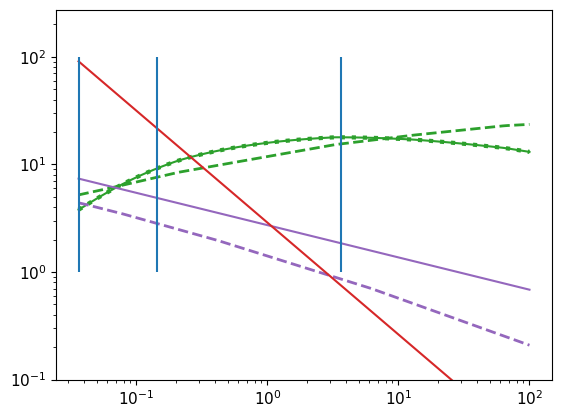

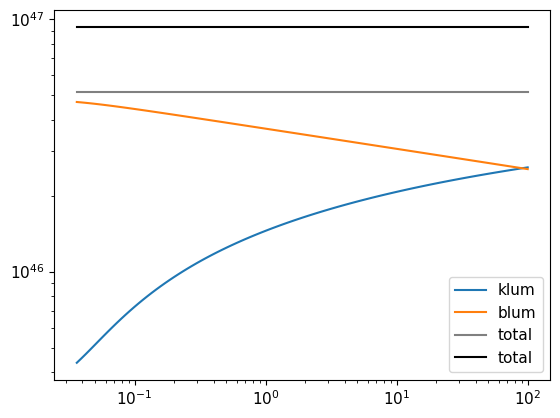



####################################

rRDR = 0.25 == 0.036190073359436255 pc
eemax::: 1.03e+06 eV
ETA_ACC(z=3.6e-02 pc): 4.11e+03
atten for z= 0.87


/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/2032702752.py:1233: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ntrapz = np.trapz(plaw, egrid)
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/2032702752.py:1235: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  etotal = np.trapz(normalized * egrid, egrid) * u.eV.to(u.erg)
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/2032702752.py:447: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  etrapz = np.trapz(epowerlaw / egrid, egrid)
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/2032702752.py:475: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions i

eemax::: 1.03e+06 eV
3 real_epmax, real_eemax: 2.20e+14 (changed to 1e17), 1.03e+06
plum = 0.0007 L_Edd (log -4.17), p/e = 1.1e+03


####################################

rRDR = 0.2701962564807477 == 0.039113689373933246 pc
eemax::: 1.70e+06 eV
ETA_ACC(z=3.9e-02 pc): 2.47e+03
atten for z= 0.87


/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:526: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_rad_power = np.trapz(jet_pho / egrid_pho, egrid_pho) * 4 * np.pi * (10**r) ** 2 * const.c.cgs.value # erg/s, jet frame
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:574: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  n_p = np.trapz(am3.get_protons() / am3.get_egrid_had(), am3.get_egrid_had()) * 4./3 * np.pi * (10**r) ** 2 * 3e10
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:575: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  n_e = np.trapz(am3.get_electrons() / am3.get_egrid_lep(), am3.get_egrid_lep()) * 4./3 * np.pi * (10**

eemax::: 1.70e+06 eV
3 real_epmax, real_eemax: 4.89e+14 (changed to 1e17), 1.70e+06
plum = 0.0009 L_Edd (log -4.05), p/e = 1.4e+03


####################################

rRDR = 0.29202406806483994 == 0.04227348978395025 pc
eemax::: 2.80e+06 eV
ETA_ACC(z=4.2e-02 pc): 1.55e+03
atten for z= 0.87
eemax::: 2.80e+06 eV
3 real_epmax, real_eemax: 9.85e+14 (changed to 1e17), 2.80e+06
plum = 0.0011 L_Edd (log -3.94), p/e = 1.6e+03


####################################

rRDR = 0.31561523997359525 == 0.04568855475200196 pc
eemax::: 4.17e+06 eV
ETA_ACC(z=4.6e-02 pc): 1.00e+03
atten for z= 0.87
eemax::: 4.17e+06 eV
3 real_epmax, real_eemax: 1.98e+15 (changed to 1e17), 4.17e+06
plum = 0.0015 L_Edd (log -3.84), p/e = 1.8e+03


####################################

rRDR = 0.3411122253165531 == 0.04937950583202642 pc
eemax::: 6.23e+06 eV
ETA_ACC(z=4.9e-02 pc): 6.69e+02
atten for z= 0.87
eemax::: 6.23e+06 eV
3 real_epmax, real_eemax: 3.61e+15 (changed to 1e17), 6.23e+06
plum = 0.0018 L_Edd (log -3.74),

/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/2032702752.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[x<threshold] *= 0
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/2032702752.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[x<threshold] *= 0
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:869: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:170: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one o

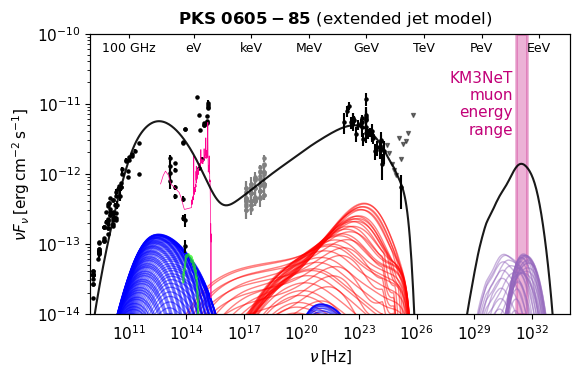

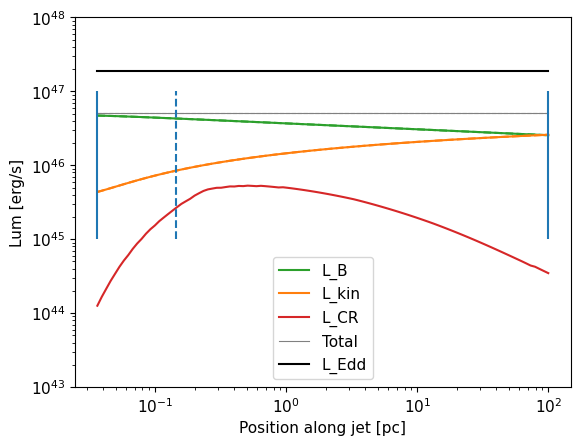

/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:920: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  elum_arr = np.array([np.trapz(ta[1] /  ta[0], ta[0]) for ta in lep_arrays])
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:921: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plum_arr = np.array([np.trapz(ta[1] /  ta[0], ta[0]) for ta in had_arrays])
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:923: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pslum_arr = np.array([np.trapz(ta['ps'] /  ta['x_pho'], ta['x_pho']) for ta in sed_arrays])
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:924: DeprecationWar

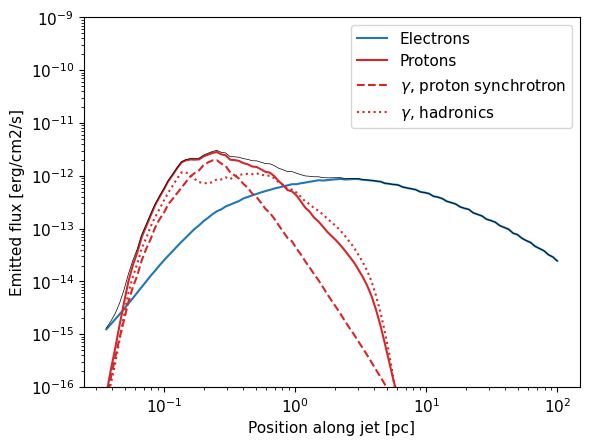

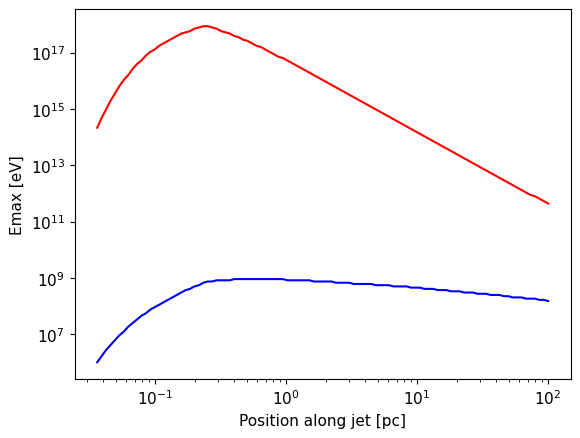

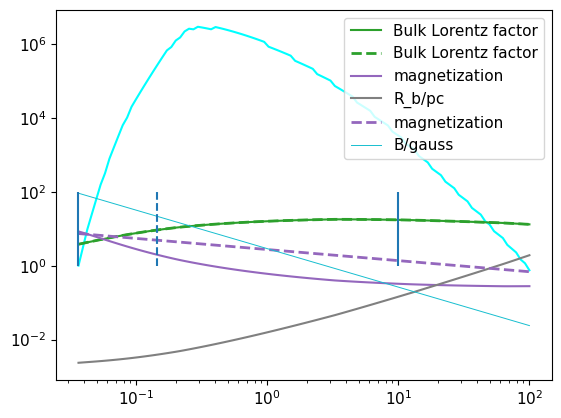

In [7]:
# for ftheta in np.arange(0.1,0.23,0.01):##np.arange(0.12,0.20,0.01):
for _ in [0]:
    etamin = 13.
    alphaeta = 1.5
    rmin = 1.7
    pjet = 0.55
    bevol = 1.04
    partfrac = 0.08
    ftheta = 0.25 #0.12
    densind = 1.78

    
    for s in CAT:
        if not CAT[s]['associated_to_alert']:
            continue
        if 'MSQ' != CAT[s]['masq']:
            continue
        # if s in solved_sources:
        #     continue
        if '0509' not in s:
            continue
        print('Source:', s)
        source=CAT[s]
        break


    Z_0605 = 0.87 # START IMPLEMENTATION HERE


    print("selected source:", s)

    nulim_x = np.load(f"/Users/xrodrigu/analysis/sin/sin-v/data/2401icecube_limits/energies_{source['association'].replace(' ', '_')}.npy")
    nulim_min = np.load(f"/Users/xrodrigu/analysis/sin/sin-v/data/2401icecube_limits/flux_low_epeak_{source['association'].replace(' ', '_')}.npy")
    nulim_max = np.load(f"/Users/xrodrigu/analysis/sin/sin-v/data/2401icecube_limits/flux_high_epeak_{source['association'].replace(' ', '_')}.npy")

    if s in ["3FGLJ0627.9-1517", "4FGLJ0344.4+3432", "3FGLJ1258.4+2123"]:
        nulim_min *= 0

    peakmin, peakmax = source['thermal_and_syn_fits']['synpeak']
    peakmin, peakmax = peakmin / ev_to_hz , peakmax / ev_to_hz
    fluxmin, fluxmax = source['thermal_and_syn_fits']['synflux']    
    eblx, ebly = source['ebl_tau']
    gex = CAT[s]['thermal_and_syn_fits']['host'][0] * 1
    gey = CAT[s]['thermal_and_syn_fits']['host'][1] * 1

    data_x = source['data2311'][0] * 1
    data_y = source['data2311'][1] * 1
    data_errlo = source['data2311'][2] * 1
    data_errup = source['data2311'][3] * 1
    detections = source['data2311'][4]
    is_uplim = (~detections) # + (data_x < (300e9)) # Now, use radio
    data_x /= ev_to_hz
    data_err = np.maximum(data_errlo,data_errup)
    binned_x, binned_y, binned_err, binned_isuplim = bin_data(data_x, data_y, data_err, is_uplim)
        
    rog = np.where((binned_x > np.log10(4e-2)) * (binned_x < np.log10(8e-2)))[0]
    binned_x, binned_y, binned_err, binned_isuplim = (np.delete(binned_x,rog),
                                                    np.delete(binned_y,rog),
                                                    np.delete(binned_err,rog),
                                                    np.delete(binned_isuplim,rog)
                                                    )

    PARAMS['sourcename'] = s
    PARAMS['z'] = Z_0605
    CAT[s]['z'] = Z_0605
    PARAMS['plum'] = 0.
    CAT[s]['M_BH'] = 10**8.87
    PARAMS['masquerading'] = 'MSQ'#source['masq']
    # PARAMS['disk_lum'] = source['thermal_and_syn_fits']['disk'][2]
    PARAMS['disk_lum'] = 10**46.3
    R_BLR = 1e17 * (PARAMS['disk_lum'] / 1e45) ** 0.5  # [cm]
    R_TORUS = 2.5e18 * (PARAMS['disk_lum'] / 1e45) ** 0.5 # [cm]

    BLR_COVERING = 0.1 / 1.5
    TORUS_COVERING = 0.3

    ###

    FTHETA = ftheta

    def jetpowerlossfactor(z, zinit=R_BLR, loss=0.0):
        # return 1.0
        return (z < zinit) + (z >= zinit) * ((z / R_BLR) ** -np.log10(1/(1-loss)))

    def model_rblob(z,lor):
        rb = z * np.sin(1./lor) * FTHETA

        return rb

    r_i = 0.25 # * u.pc.to(u.cm) / R_BLR # 9e16/R_BLR # WAS 9e16 # 0.3
    r_f = 100 * u.pc.to(u.cm) / R_BLR #/R_BLR
    ZONES_PER_DECADE = 30
    RDR_ARR = np.logspace(np.log10(r_i), # R_BLR = 6e16
                        np.log10(r_f),int(ZONES_PER_DECADE * np.log10(r_f/r_i)))  #          ARRAY         ---------________---------

    # R_FLARE = 1.1e17
    # NFRAC_FLARE = 1.7e-6
    # RDR_ARR = np.array(list(RDR_ARR) + [R_FLARE/R_BLR])


    def model_b_from_blum_bhf(z, lor, blum_bhf):
        rblob = model_rblob(z,lor)
        blum_jetframe = blum_bhf / lor ** 2
        b = 2/rblob * (blum_jetframe / const.c.cgs.value) ** 0.5
        return b


    PJET = eddington_lum(CAT[s]['M_BH']) * pjet 
    R_INIT = 3 * schwarzschild(CAT[s]['M_BH'])
    LOR_INIT = 1.
    B_INIT = model_b_from_blum_bhf(R_INIT, LOR_INIT, PJET)
    print(f"B_INIT: {B_INIT:.1e} G")
    B_EVOL = bevol ### 1.11

    BLR_COL_DEN = 1e24

    CUTOFF_POWER = R_INIT
    PART_FRAC = partfrac
    DENS_INDEX = densind 

    SIMTIME = 3


    ETA0 = etamin
    ETAS = alphaeta
    R_ETAMIN = rmin
    def ETA_ACC(z):
        z_peak = R_ETAMIN * R_BLR
        eta_peak = 1 / ETA0
        alpha = ETAS  # power-law index for the tail2

        def ecore(x):    
            rea_ratio = z_peak / x
            exp_core = 1. / (np.exp(- (rea_ratio)**1.0))
            return exp_core

        def plaw(x):
            power_law = 1. / (eta_peak * (x / z_peak) ** -alpha)
            power_law = np.maximum(power_law, power_law*0+ETA0)
            return power_law
        
        sample_array = R_BLR * np.logspace(-3,3,100)
        return (ecore(z) * plaw(z)) / eta_peak / np.min(ecore(sample_array) * plaw(sample_array))


    ACC_ALPHA = 0.3

    EEMAX = 0 # 3e10 #m_p_ev 
    EPMAX = 0 #3e18

    PIND = 1.8
    EIND = 1.8

    # FRACTION OF **NONTHERMAL** PARTICLES DRAWN FROM THE THERMAL PLASMA POOL
    NP_FRAC = 4.2e-06 # 2.6e-5
    NE_FRAC = 9e-5 # 3.0e-4

   

    THETA_OBS = 0.6 * np.pi / 180.


    def model_b(z, binit=B_INIT, bevol=B_EVOL, rinit=R_INIT):
        b = binit * (z/rinit) ** -bevol
        return b


    def model_n_implicit(z, lor, dens_index=DENS_INDEX, partfrac=PART_FRAC, blr_col_den=BLR_COL_DEN):
        dens_dist_unnorm = lambda x: x ** - dens_index
        integ = np.trapz(dens_dist_unnorm(np.logspace(np.log10(6e15),np.log10(R_BLR),100)), np.logspace(np.log10(6e15),np.log10(R_BLR),100))
        densdist = dens_dist_unnorm(z) * blr_col_den / integ # [cm-3] ENVIRONMENT!!! 
        rblob = model_rblob(z,lor)
        beta = (1 - 1. / lor ** 2) ** 0.5
        n = densdist * np.pi * rblob ** 2 * partfrac * const.c.cgs.value * lor * beta # medium contraction
        # n *= volume_correction(z,lor) 
        return n

    def model_blum_bhf(z, lor, binit=B_INIT, bevol=B_EVOL, rinit=R_INIT):
        b = model_b(z,binit,bevol,rinit)
        rblob = model_rblob(z,lor)
        blum = maglum(b,rblob) * lor ** 2
        # blum *= volume_correction(z,lor)
        blum *= jetpowerlossfactor(z,rinit)

        return blum

    def model_klum_bhf(z, lor, lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, dens_index=DENS_INDEX, binit=B_INIT, bevol=B_EVOL, blr_col_den=BLR_COL_DEN):
        ''' In the black hole rest frame.
        '''
        n_init = model_n_implicit(rinit, lorinit, dens_index, partfrac, blr_col_den)
        klum_init = n_init * (const.m_p * const.c**2).to(u.erg).value * (lorinit-1) 

        blum_init = model_blum_bhf(rinit, lorinit, binit, bevol, rinit) 
        total_init = klum_init + blum_init
        # total_init *= volume_correction(z,lor) / volume_correction(rinit,lorinit)

        blum_at_z = model_blum_bhf(z, lor, binit, bevol, rinit)
        klum_at_z = total_init * jetpowerlossfactor(z,rinit) - blum_at_z
        

        
        if np.any(klum_at_z < 0.):
            print(f"[model_klum_bhf]Error: some klum vals are negative: {np.min(klum_at_z):.1e}. Increase initial Lorentz factor or decrease B evolution!")
        return klum_at_z


    def model_lor(z, lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, dens_index=DENS_INDEX, binit=B_INIT, bevol=B_EVOL, blr_col_den=BLR_COL_DEN):
        lor = get_prescribed('lor', z)
        klum = model_klum_bhf(z, lor, lorinit, rinit, partfrac, dens_index, binit, bevol, blr_col_den)
        n = model_n_implicit(z, lor, dens_index, partfrac, blr_col_den)   
        lor = (klum / n / (const.m_p * const.c**2).to(u.erg).value) + 1
        
        if np.any(klum < 0):
            print("[model_lor]Warning:", np.sum(klum < 0), "negative L_kin vals ! Returning Gamma_bulk = 1  for those cases.")
            lor = np.where(klum<0,lor*0+1,lor)

        n = model_n_implicit(z, lor, dens_index, partfrac, blr_col_den)# model_n(z, lor, index=dens_index, partfrac=partfrac, blr_col_den=blr_col_den)
        klum = model_klum_bhf(z, lor, lorinit, rinit, partfrac, dens_index, binit, bevol, blr_col_den)
        lor = (klum / n / (const.m_p * const.c**2).to(u.erg).value) + 1

        return lor

    def model_n(z, lor, lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, dens_index=DENS_INDEX, blr_col_den=BLR_COL_DEN, binit=B_INIT, bevol=B_EVOL):
        klum = model_klum_bhf(z, lor, lorinit, rinit, partfrac, dens_index, binit, bevol, blr_col_den)
        n = klum / ((lor-1) * MPERG)   # medium contraction
        return n

    def model_den(z, lor, lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, dens_index=DENS_INDEX, blr_col_den=BLR_COL_DEN, binit=B_INIT, bevol=B_EVOL):
        n = model_n(z, lor, lorinit, rinit, partfrac, dens_index, blr_col_den, binit, bevol)
        rblob = model_rblob(z,lor)
        den = n / (np.pi * rblob ** 2 * const.c.cgs.value) / lor # time dilation in the jet
        return den

    def model_magnetization(z, lor, lorinit=LOR_INIT, partfrac=PART_FRAC, dens_index=DENS_INDEX, binit=B_INIT, bevol=B_EVOL, rinit=R_INIT, blr_col_den=BLR_COL_DEN):
        b = model_b(z,binit,bevol,rinit)

        dens_dist_unnorm = lambda x: x ** - dens_index
        integ = np.trapz(dens_dist_unnorm(np.logspace(np.log10(6e15),np.log10(R_BLR),100)), np.logspace(np.log10(6e15),np.log10(R_BLR),100))
        densdist = dens_dist_unnorm(z) * blr_col_den  * partfrac / integ # [cm-3] thermal 
        sigma = calc_sigma(b,densdist)
        return sigma

    # def model_lor_double(z, lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, dens_index=DENS_INDEX, binit=B_INIT, bevol=B_EVOL, blr_col_den=BLR_COL_DEN):
    #     mperg = (const.m_p * const.c ** 2).to(u.erg).value
        
    #     def f(lor):
    #         klum = model_klum_bhf(z, lor, lorinit, rinit, partfrac, dens_index, binit, bevol, blr_col_den)
    #         blum = model_blum_bhf(z, lor, binit, bevol, rinit)
    #         n = 10 ** 45 * 100 #model_n(z, lor, index=dens_index, partfrac=partfrac, blr_col_den=blr_col_den)
    #         print(f"klum: {klum} erg/s")
    #         print(f"n: {n * mperg} erg/s. z={z}, lor={lor}")
    #         return lor - 1 - (klum) / (n * mperg)

    #     from scipy.optimize import root_scalar
    #     root = root_scalar(f, bracket=[1.01, 1e30], method="brentq").root
    #     lor = root

    #     return lor

    # model_lor = np.vectorize(lambda z: model_lor_double(z, lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, dens_index=DENS_INDEX, binit=B_INIT, bevol=B_EVOL, blr_col_den=BLR_COL_DEN))


    # def model_lor2(z, lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, dens_index=DENS_INDEX, binit=B_INIT, bevol=B_EVOL, blr_col_den=BLR_COL_DEN):
    #     mperg = (const.m_p * const.c ** 2).to(u.erg).value
    #     lor = get_prescribed('lor', z)
    #     klum = (z, lor, lorinit, rinit, partfrac, dens_index, binit, bevol, blr_col_den):
    #     n = model_n(z, lor, index=dens_index, partfrac=partfrac, blr_col_den=blr_col_den)
    #     f = lambda lor: lor - 1 - klum / (n * mperg)

    #     from scipy.optimize import fsolve
    #     root = fsolve(f,100.)
        
    #     return root
    # mliv = np.vectorize(lambda z: model_lor2(z, lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, dens_index=DENS_INDEX, binit=B_INIT, bevol=B_EVOL, blr_col_den=BLR_COL_DEN))

    # def setup_model():



    f3 = plt.figure()


    rarr = RDR_ARR * R_BLR 
    # rarr = np.logspace(np.log10(R_INIT), np.log10(RDR_ARR[-1] * R_BLR), 100)

    magnet_presc_arr = np.array([get_prescribed('mag', r) for r in rarr])
    lor_presc_arr = np.array([get_prescribed('lor', r) for r in rarr])
    rblob_presc_arr = rarr * np.sin(1./lor_presc_arr)


    lorarr = model_lor(rarr)
    magarr = model_magnetization(rarr, lorarr)
    barr = model_b(rarr)
    narr = model_n(rarr,lorarr)
    mperg = (const.m_p * const.c**2).to(u.erg).value

    klarr = model_klum_bhf(rarr, lorarr)
    blarr = model_blum_bhf(rarr, lorarr)



    plt.loglog(rarr*u.cm.to(u.pc), lorarr,c='tab:green')
    # plt.loglog(rarr*u.cm.to(u.pc), mliv(rarr),c='m',lw=3,ls=':')
    plt.loglog(rarr*u.cm.to(u.pc), lor_presc_arr, c='tab:green', ls='--',lw=2)
    plt.loglog(rarr*u.cm.to(u.pc), klarr / (narr * mperg) + 1, c='tab:green', ls=':',lw=3.)


    plt.loglog(rarr*u.cm.to(u.pc), magarr, c='tab:purple')
    plt.loglog(rarr*u.cm.to(u.pc), magnet_presc_arr,c='tab:purple',ls='--',lw=2)

    plt.loglog(rarr*u.cm.to(u.pc), barr, c='tab:red')

    plt.vlines([RDR_ARR[0] * R_BLR * u.cm.to(u.pc), R_BLR*u.cm.to(u.pc),R_TORUS*u.cm.to(u.pc)], 1e0,1e2,ls=['-', '-', '-'])

    plt.ylim([1e-1,np.max(np.concatenate([lorarr,klarr / (narr * mperg) + 1, magarr, barr]))*3])

    plt.show()



    plt.loglog(rarr*u.cm.to(u.pc), klarr,label='klum')
    plt.loglog(rarr*u.cm.to(u.pc), blarr,label='blum')
    plt.loglog(rarr*u.cm.to(u.pc), (blarr+klarr),c='gray',label='total')
    plt.loglog(rarr*u.cm.to(u.pc), rarr*0 + eddington_lum(CAT[s]['M_BH']),c='k',label='total')
    plt.legend()
    # plt.loglog(rarr, [get_prescribed('lor', r) for r in rarr], ls='--')

    plt.show()



    plt.close()


    ##########################################################################################################################################################################################################################################################################################################################################################################################
    ##########################################################################################################################################################################################################################################################################################################################################################################################
    #break
    ##########################################################################################################################################################################################################################################################################################################################################################################################
    ##########################################################################################################################################################################################################################################################################################################################################################################################




    GAMMAMIN = lambda lor: 100. # lor DEBUG@ -- effect on NNT

    def compute_parameters(rdr, lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, binit=B_INIT, bevol=B_EVOL):#### Compute self-consistent jet parameters


        z = rdr * R_BLR
        
        ealpha = EIND
        pind = PIND
        
        real_lor = model_lor(z)
        real_rblob = model_rblob(z, real_lor)
        # real_magnetization = model_magnetization(z, real_lor)
        real_n = model_n(z, real_lor)
        real_den = model_den(z, real_lor)
        real_b = model_b(z)
        # DEBUG: test Lorentz-dependent threshold hypothesis for electrons
        esti_eemax = EEMAX if EEMAX else am3.get_egrid_lep()[get_imax('e', ETA_ACC(z), real_b, real_rblob, cool=True, esc=False, include_compton=False, secondorder=1, number_density=real_den, alpha=ACC_ALPHA)] 
        esti_epmax = am3.get_egrid_had()[get_imax('p', ETA_ACC(z), real_b, real_rblob, cool=False, esc=True, include_compton=False, secondorder=1, number_density=real_den, alpha=ACC_ALPHA)]

        real_lum_e = get_etotal_from_number(real_n * NE_FRAC, ealpha, GAMMAMIN(real_lor) * m_e_ev, esti_eemax)
        real_lum_p = get_etotal_from_number(real_n * NP_FRAC, pind, GAMMAMIN(real_lor) * m_p_ev, esti_epmax)

        # Calculate parameters
        r = np.log10(real_rblob)
        b = np.log10(real_b)
        egmax = np.log10(esti_eemax / m_e_ev)
        elum = np.log10(real_lum_e)
        lor = np.log10(real_lor)
        plum = np.log10(real_lum_p)
        pgmax = np.log10(esti_epmax / m_p_ev)

        return r, b, egmax, ealpha, elum, lor, rdr, plum, pgmax, pind


    # # Double-check particle numbers
    # n_p = get_n_total(pind, m_p_ev * real_lor, esti_epmax, real_lum_p)
    # n_e = get_n_total(ealpha, m_e_ev * real_lor, esti_eemax, real_lum_e)
    # lum_cold = real_n * (const.m_p * const.c ** 2).cgs.value * real_lor
    # lum_mag = real_b ** 2 * (real_rblob) ** 2 * 3e10
    # # Double-checkl derived magnetization
    # sigma = magnetization(real_b, n_p * real_lor, (real_lum_e + real_lum_p)*1, real_rblob) 


    ### Plot
    plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 11
    plt.rcParams['axes.labelsize'] = 11
    plt.rcParams['legend.fontsize'] = 11
    plt.rcParams['axes.titlesize'] = 11
    plt.rcParams['font.size'] = 11

    plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 11
    plt.rcParams['axes.labelsize'] = 11
    plt.rcParams['legend.fontsize'] = 11
    plt.rcParams['axes.titlesize'] = 11
    plt.rcParams['font.size'] = 11

    colors = ["#FF0000", "#00FF00", "#0000FF", "k", "#FF00FF", "#00FFFF", "#800000", "#008000", "#000080", "#808000", "#800080", "#008080", "#FFA500", "#A52A2A", "#800080", "#008080", "#ADD8E6", "#FFC0CB", "#FF4500", "#800000", "#8B4513", "#2E8B57", "#8B008B", "#000080", "#4B0082", "#228B22", "#D2691E", "#FFD700", "#7CFC00", "#20B2AA", "#6A5ACD", "#9400D3", "#DC143C", "#191970", "#8A2BE2", "#A9A9A9", "#696969", "#D3D3D3", "#000000", "#FFFFFF", "#F0F8FF", "#FAEBD7", "#00FFFF", "#7FFFD4", "#F0FFFF", "#F5F5DC", "#FFE4C4", "#000000", "#F8F8FF", "#FFEBCD"]


    # Energy arrays in source frame
    egrid_pho = am3.get_egrid_photons()
    egrid_nu = am3.get_egrid_neutrinos()

    fig1 = plt.figure(figsize=(6,4))
    ax1 = plt.gca()

    carr = list(mycolors) * 100

    total_arrays = []
    lep_arrays = []
    had_arrays = []
    total_nus = []
    rate_arrays = []
    sed_arrays = []
    total_edd = 0.


    for ic, (rdr, c) in enumerate(zip(RDR_ARR, carr)):
        
        z = rdr * R_BLR

        PLOT_ALL = False
        if ic == 3:
            PLOT_ALL = False


        # if ic == RDR_ARR.size - 1:
        #     NP_FRAC = NFRAC_FLARE
        #     NE_FRAC = NFRAC_FLARE
    

        print("\n\n####################################\n\n"+f"rRDR = {rdr} == {rdr * R_BLR * u.cm.to(u.pc)} pc")

        r, b, egmax, ealpha, elum, lor, _, plum, pgmax, pind = compute_parameters(rdr, lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, binit=B_INIT, bevol=B_EVOL)
        

        print(f"ETA_ACC(z={z*u.cm.to(u.pc):.1e} pc): {ETA_ACC(z):.2e}")                                              


        real_rblob = 10 ** r #model_rblob(z, real_lor)
        real_b = 10 ** b # model_b(z, binit=B_INIT, bevol=B_EVOL, rinit=R_BLR)
        real_lor = 10 ** lor#model_lor(z, lorinit=LOR_INIT, rinit=R_BLR, partfrac=PART_FRAC, densdist=DENS_DIST, binit=B_INIT, bevol=B_EVOL)
        real_n = model_n(z, real_lor)
        real_den = model_den(z, real_lor)


        dopp = doppler_factor(THETA_OBS, real_lor)

        # Energy arrays in the observer's frame

        egrid_obs = egrid_pho * dopp / (1 + PARAMS['z'])
        egrid_nu_obs = egrid_nu * dopp / (1 + PARAMS['z'])
        atten = dominguez.evaluate(egrid_obs * u.eV, CAT[s]['z'], 1.0)
        print('atten for z=', CAT[s]['z'])
        # SIMULATION

        PARAMS['egammamin'] = GAMMAMIN(real_lor)

        # if rdr == RDR_ARR[0]: b -= 0.0                                                                                 #### ADJUSTMENTS

        escaped = cost_function(r, b, egmax, ealpha, elum, lor, rdr, plum, pgmax, pind, pgmin=np.log10(GAMMAMIN(real_lor)))

        imaxp = get_imax('p', ETA_ACC(z), 10**b, 10**r, cool=True, esc=True, include_compton=False,secondorder=1, number_density=real_den, alpha=ACC_ALPHA)
        imaxe = get_imax('e', ETA_ACC(z), 10**b, 10**r, cool=True, esc=True, include_compton=True,secondorder=1, number_density=real_den, alpha=ACC_ALPHA)

        real_epmax = EPMAX if EPMAX else am3.get_egrid_had()[imaxp]
        real_eemax = EEMAX if EEMAX else am3.get_egrid_lep()[imaxe] 

        print("3 real_epmax, real_eemax:", f"{real_epmax:.2e} (changed to 1e17), {real_eemax:.2e}")
        

        if (real_epmax > (10**pgmax * m_p_ev) * 1.05 or 
            real_epmax < (10**pgmax * m_p_ev) / 1.05 or
            real_eemax > (10**egmax * m_e_ev) * 1.05 or 
            real_eemax < (10**egmax * m_e_ev) / 1.05):
            print(f"PGammaMax ADJUSTMENT: was {10**pgmax:.2e}, is {real_epmax / m_p_ev:.2e}")
            pgmax = np.log10(real_epmax / m_p_ev)
            egmax = np.log10(real_eemax / m_e_ev)
            real_lum_e = get_etotal_from_number(real_n * NE_FRAC, ealpha, GAMMAMIN(real_lor) * m_e_ev, real_eemax)
            real_lum_p = get_etotal_from_number(real_n * NP_FRAC, pind, GAMMAMIN(real_lor) * m_p_ev, real_epmax)  # REAL_N? ##
            elum = np.log10(real_lum_e)
            plum = np.log10(real_lum_p)

            escaped = cost_function(r, b, egmax, ealpha, elum, lor, rdr, plum, pgmax, pind, pgmin=np.log10(GAMMAMIN(real_lor)))

        edd_jetframe = (eddington_lum(CAT[s]['M_BH']) * 2 / (10**lor) ** 2)
            
        

        # print("r, b, egmax, ealpha, elum, lor, rdr, plum, pgmax, pind:")
        # print(r, b, egmax, ealpha, elum, lor, rdr, plum, pgmax, pind)
        # print(f"{'z':20s} {z:.2e} (R_BLR = {R_BLR:.2e})")
        # print(f"{'lor':20s} {10**lor:.2e}")
        # print(f"{'n (elec, prot):':20s} {real_n:.2e}, {real_n * NP_FRAC:.2e}")
        # # print(f"{'lum_e':20s} {real_lum_e:.2e}")
        # # print(f"{'lum_p':20s} {real_lum_p:.2e}")
        # print(f"{'esti_eemax':20s} {real_eemax:.2e} eV")
        # print(f"{'esti_epmax':20s} {real_epmax:.2e} eV")
        # print(f"{'magnetization':20s} {magnetization:.2e}")
        # print(f"{'B-field:':20s} {10**b:.2e}")
        # print(f"{'Luminosities (cold, hot, mag, total, Edd, fraction):':20s} {lum_cold:.2e}, {real_lum_p:.2e}, {lum_mag:.2e}, {lum_jet:.2e}, {edd_jetframe:.2e} {lum_jet/edd_jetframe:.2e}")


        all_nu = am3.get_neutrinos() * egrid_nu * u.eV.to(u.erg)
        external_pho = am3.get_injection_rate_photons() * am3.get_escape_timescale() *  egrid_pho * u.eV.to(u.erg)
        leptonic = am3.get_photons_injected_electrons_syn_compton() * egrid_pho * u.eV.to(u.erg)
        syn = am3.get_photons_injected_electrons_syn() * egrid_pho * u.eV.to(u.erg)
        icompton = am3.get_photons_injected_electrons_compton() * egrid_pho * u.eV.to(u.erg)
        annihil = am3.get_photons_annihilation_pairs_syn_compton() * egrid_pho * u.eV.to(u.erg)
        all_photons = am3.get_photons() * egrid_pho * u.eV.to(u.erg)
        bheitler = am3.get_photons_bethe_heitler_pairs_syn_compton() * egrid_pho * u.eV.to(u.erg)
        pgamma = am3.get_photons_photo_pion_pairs_syn_compton() * egrid_pho * u.eV.to(u.erg)
        pi0decay = am3.get_photons_pi0_decay() * egrid_pho * u.eV.to(u.erg)
        proton_syn_ic = am3.get_photons_protons_syn_compton() * egrid_pho * u.eV.to(u.erg)
        jet_pho = am3.get_photons_except_injected() *  egrid_pho * u.eV.to(u.erg)
        totals = jet_pho# + 10 ** np.interp(np.log10(egrid_obs), 
                        #               np.log10(gex / ev_to_hz / (1 + source['z'])), 
                        #              np.log10(gey),left=-100,right=-100)
        hadronic = annihil + bheitler + pgamma + pi0decay + proton_syn_ic


        total_rad_power = np.trapz(jet_pho / egrid_pho, egrid_pho) * 4 * np.pi * (10**r) ** 2 * const.c.cgs.value # erg/s, jet frame

        rate_arrays.append({'x_lep' : am3.get_egrid_lep() * 1.0,
                            'x_had' : am3.get_egrid_had() * 1.0,
                            'x_pho' : am3.get_egrid_photons() * 1.0,
                            'annil' : am3.get_t_photon_annihilation(),
                            'ecool' : 1/(1/am3.get_t_pair_syn() + 1/am3.get_t_pair_compton()),
                            'esyn' : am3.get_t_pair_syn(),
                            'ecom' : am3.get_t_pair_compton(),
                            'pcool' : 1/(1/am3.get_t_proton_photopion() + 1 / am3.get_t_proton_bethe_heitler() + 1 / am3.get_t_proton_syn()),
                            'pcool_pgamma' : am3.get_t_proton_photopion(),
                            'pcool_behei' : am3.get_t_proton_bethe_heitler(),
                            'pcool_syn' : am3.get_t_proton_syn(),
                            'acc1' : calc_accel(am3.get_egrid_lep(), ETA_ACC(z), 10 ** b, stoch=False),
                            'acc2' : calc_accel(am3.get_egrid_lep(), ETA_ACC(z), 10 ** b, stoch=True, coherence_scale=10**r, number_density=real_den),
                            'tau_stoch' : tau_stoch(am3.get_egrid_had(), 
                                                    10 ** b, 
                                                    coherence_scale=10 ** r,
                                                    eta=ETA_ACC(z)),
                            'eta' : ETA_ACC(z),
                            'emax_e' : 10 ** egmax * (const.m_e * const.c ** 2).to(u.eV).value,
                            'emax_p' : 10 ** pgmax * (const.m_p * const.c ** 2).to(u.eV).value,
                            'b' : 10 ** b,
                            'lor' : 10 ** lor,
                            'r' : 10 ** r,
                            'kinlum' : model_klum_bhf(z, 10 ** lor),
                            'maglum' : model_blum_bhf(z, 10 ** lor),
                            'crlum' : 10 ** plum,
                            'radlum' : total_rad_power,
                            'elum' : 10 ** elum,
                            'eddlum' : edd_jetframe,
                            'n' : real_n,
                            'rho' : real_den,
                            'ele_curr' : am3.get_electrons(),
                            'eesc' : am3.get_t_pair_escape(),
                            'eesc_bohm' : 10 ** r * (10 ** r / larmor(am3.get_egrid_lep(), 10 ** b)) / const.c.cgs.value,
                            'pesc' : am3.get_t_proton_escape(),
                            # 'nesc' : am3.get_t_neutron_escape(),
                            'ele_inje' : am3.get_injection_rate_electrons(),
                            'pro_curr' : am3.get_protons(),
                            'pro_inje' : am3.get_injection_rate_protons(),
                            'escaped' : escaped
                        })
        # PJET -= 10 ** plum * (10 ** lor) ** 2
        

        plt.figure(fig1.number)

        n_p = np.trapz(am3.get_protons() / am3.get_egrid_had(), am3.get_egrid_had()) * 4./3 * np.pi * (10**r) ** 2 * 3e10
        n_e = np.trapz(am3.get_electrons() / am3.get_egrid_lep(), am3.get_egrid_lep()) * 4./3 * np.pi * (10**r) ** 2 * 3e10

        l_p = np.trapz(am3.get_protons(), am3.get_egrid_had()) * 4./3 * np.pi * (10**r) ** 2 * 3e10 * u.eV.to(u.erg)
        l_e = np.trapz(am3.get_electrons(), am3.get_egrid_lep()) * 4./3 * np.pi * (10**r) ** 2 * 3e10 * u.eV.to(u.erg)

        m_e_ev = (const.m_e*const.c**2).to(u.eV).value
        m_p_ev = (const.m_p*const.c**2).to(u.eV).value

        # GET CONVERSION FACTORS 
    
        density_to_lum = 4 * np.pi * (10**r) ** 2 * const.c.cgs.value            
        spectrum_conversion = density_to_lum * dopp ** 4 / (4 * np.pi * (cosmo.luminosity_distance(PARAMS['z']).cgs.value) ** 2) * np.log(10) / ZONES_PER_DECADE

        # Energy arrays in source frame

        hadronic_obs = hadronic * spectrum_conversion
        leptonic_obs = leptonic * spectrum_conversion
        syn_obs = syn * spectrum_conversion
        icompton_obs = icompton * spectrum_conversion
        pp_obs = annihil * spectrum_conversion
        ps_obs = proton_syn_ic * spectrum_conversion
        bh_obs = bheitler * spectrum_conversion
        pi0_obs = pi0decay * spectrum_conversion
        pg_obs = pgamma * spectrum_conversion
        all_nu_obs = all_nu * spectrum_conversion
        jet_obs = jet_pho * spectrum_conversion

        total_arrays.append([egrid_obs, jet_obs, atten])
        lep_arrays.append([egrid_obs, leptonic_obs, atten])
        had_arrays.append([egrid_obs, hadronic_obs, atten])
        total_nus.append([egrid_nu_obs, all_nu_obs])

        protons = am3.get_protons() * am3.get_egrid_had() * u.eV.to(u.erg)
        electrons = am3.get_electrons() * am3.get_egrid_lep() * u.eV.to(u.erg)



        sed_arrays.append({'x_lep' : am3.get_egrid_lep() * 1.0,
                            'x_had' : am3.get_egrid_had() * 1.0,
                            'x_pho' : am3.get_egrid_photons() * 1.0,
                            'x_nu' : am3.get_egrid_neutrinos() * 1.0,
                            'x_pho_obs' : egrid_obs * 1.0,
                            'x_nu_obs' : egrid_nu_obs * 1.0,
                            'hadronic' : hadronic_obs * 1.0,
                            'syn' : syn_obs * 1.0,
                            'icompton' : icompton_obs * 1.0,
                            'pp' : pp_obs * 1.0,
                            'ps' : ps_obs * 1.0,
                            'pi0' : pi0_obs * 1.0,
                            'bh' : bh_obs * 1.0,
                            'pg' : pg_obs * 1.0,
                            'all_nu' : all_nu_obs * 1.0,
                            'total' : jet_obs  * 1.0,
                            'nupeak' : am3.get_egrid_neutrinos()[np.argmax(all_nu_obs)]
                        })



        # plt.loglog(egrid_obs * ev_to_hz, leptonic_obs * atten,ls='--',zorder=100,
        #     lw=1.5,alpha=0.5,color=c)

        lw=1.0

        # plt.loglog(egrid_obs * ev_to_hz, jet_obs * atten,ls='-', # hadronic_obs
        #     lw=lw,alpha=0.5,color=c,label=f'{rdr:.1f} R_BLR')

        plt.loglog(egrid_obs * ev_to_hz, hadronic_obs * atten,ls='-', # hadronic_obs
            lw=lw,alpha=0.5,color='red',label=f'{rdr:.1f} R_BLR')
        plt.loglog(egrid_obs * ev_to_hz, leptonic_obs * atten,ls='-', # hadronic_obs
            lw=lw,alpha=0.5,color='blue',label=f'{rdr:.1f} R_BLR')
        
        # plt.loglog(egrid_obs * ev_to_hz, bh_obs * atten,ls='-.',
        #     lw=1.5,alpha=0.5,color=c)
        
        # plt.loglog(egrid_obs * ev_to_hz, pp_obs * atten,ls=':',
        #     lw=1.5,alpha=0.5,color=c)

        # plt.loglog(egrid_obs * ev_to_hz, ps_obs  * atten,ls='--',
        #     lw=1.5,alpha=0.5,color=c)



        # plt.loglog(egrid_obs * ev_to_hz, pg_obs  * atten,ls='--',
        #     lw=1.5,alpha=0.5,color=c,label=f'{rdr:.1f} R_BLR')

        # Plot all-flavor neutrino spectrum
        plt.loglog(egrid_nu_obs * ev_to_hz, all_nu_obs  / 3.,zorder=100,
                lw=1.0, color='tab:purple',alpha=0.5)

        el = 10 ** elum
        pl = 10 ** plum
        lr = 10 ** lor
        eddlum = np.array(eddington_lum(CAT[s]['M_BH']))
        pe = pl * lr ** 2 / 2 / eddlum
        ee = el * lr ** 2 / 2 / eddlum
        total_edd += np.array([pe,ee])
        print(f"plum = {pe:.4f} L_Edd (log {np.log10(pe/10):.2f}), p/e = {pe/ee:.1e}")


    # PHOTONS

    total_x = total_arrays[0][0]
    print("TOTAL_X NANMAX:", np.nanmax(total_x))

    total_y = total_arrays[0][1] * 0
    total_y_unatten = total_arrays[0][1] * 0
    # total_photons_escaped = total_arrays[0][1] * 0

    for (x,y,att), di in zip(total_arrays, rate_arrays):
        if np.all(np.isnan(y)):
            print("z=", z, "y is all NaNs")
            continue
        total_y = np.nansum([total_y, np.interp(total_x, x, y * att)], axis=0)
        total_y_unatten = np.nansum([total_y_unatten, np.interp(total_x, x, y)], axis=0) 
        # total_photons_escaped += np.interp(total_x, x, di['escaped']['g'] / di['r']*const.c.cgs.value * di['lor'] ** 4 / (4 * np.pi * (cosmo.luminosity_distance(PARAMS['z']).cgs.value) ** 2) * att)

    ## NEUTRINOS
    totalnu_x = total_nus[0][0]
    totalnu_y = total_nus[0][1] * 0 

    for x,y in total_nus:
        totalnu_y += np.interp(totalnu_x, x, y)

    ## EBL ATTENUATION

    # xprop, pointsource, eblcascades, pairs = propagate(total_x * (1 + PARAMS['z']), total_y_unatten, z_source=PARAMS['z'], igmf_gauss=1e-16, include_cascade=True, delta_t=0.01)

    # plt.loglog(xprop * ev_to_hz, pointsource, ls='-',zorder=100,
    #     lw=1.5,alpha=0.5,color='k')


    # plt.loglog(total_x * ev_to_hz, total_y_unatten, ls='--',zorder=2000,
    #     lw=1.5,alpha=0.5,color='k')

    # total_y += 10 ** np.interp(np.log10(total_x), np.log10(get_giant_elliptical(PARAMS['z'])[0]/ev_to_hz), 
    #                            np.log10(get_giant_elliptical(PARAMS['z'])[1]), left=-100,right=-100)



    plt.loglog(total_x * ev_to_hz, total_y, ls='-',zorder=2000,
        lw=1.5,alpha=0.9,color='k')

    plt.loglog(totalnu_x * ev_to_hz, totalnu_y / 3., ls='-',zorder=2000,
        lw=1.5,alpha=0.9,color='k')



    plt.xlabel(r"$\nu\,[\mathrm{Hz}]$")
    plt.ylabel(r"$\nu F_\nu\,[\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1}]$")

    plt.annotate(f"{PARAMS['sourcename']}\nPhoton emission\nJet rest frame", 
                (3e-7,8e-2), 
                fontsize=13, 
                horizontalalignment='left')

    # plt.legend(loc='lower left', fontsize=8,frameon=1,ncol=1)

    # Load the CSV file into a pandas DataFrame
    data = pd.read_csv("/Users/xrodrigu/analysis/sin/sin-v/analysis/PKS_0605-08_mw_data.csv")  # Replace with the actual filename

    # Convert 'Is Upper Limit' to boolean (optional but useful)
    data['Is Upper Limit'] = data['Is Upper Limit'].astype(bool)

    # 0605 DATA

    dataran = ~((data['Energy'] > 1e2) * (data['Energy'] < 1e7))

    plt.scatter(data['Energy'][dataran][data['Is Upper Limit'] == 0] * ev_to_hz,
                data['Flux Value'][dataran][data['Is Upper Limit'] == 0],
                s=5,c='k',
                alpha=1.0)

    plt.scatter(data['Energy'][dataran][data['Is Upper Limit']] * ev_to_hz,
                data['Flux Value'][dataran][data['Is Upper Limit']],
                s=8,c='k',
                marker="v",
                alpha=0.5)

    plt.errorbar(data['Energy'][dataran][data['Is Upper Limit'] == 0] * ev_to_hz,
                data['Flux Value'][dataran][data['Is Upper Limit'] == 0],
                data['Flux Error'][dataran][data['Is Upper Limit'] == 0],
                ls='none',
                color='k')
    
    data1 = data  # Assuming your first dataset is already named `data`

    x1 = data1['Energy'][dataran]
    y1 = data1['Flux Value'][dataran]
    e1 = data1['Flux Error'][dataran]
    u1 = data1['Is Upper Limit'][dataran].astype(bool)


    # FIRMAMENTO DATA

    data = pd.read_csv("/Users/xrodrigu/Downloads/_5598929458_Sed.csv")
    data2 = data

    firran = (data['freq. '] > 1e2*ev_to_hz) * (data['freq. '] < 1e7*ev_to_hz)

    plt.scatter(data['freq. '][firran][data['flag'] == '  '],
                data['flux '][firran][data['flag'] == '  '],
                s=5,c='gray',
                alpha=1.0)

    plt.scatter(data['freq. '][firran][data['flag'] == 'UL'],
                data['flux '][firran][data['flag'] == 'UL'],
                s=8,c='gray',
                marker="v",
                alpha=0.5)

    plt.errorbar(data['freq. '][firran][data['flag'] == '  '],
                data['flux '][firran][data['flag'] == '  '],
                data['err_flux '][firran][data['flag'] == '  '],
                ls='none',
                color='gray',
                alpha=1.0)



    x1 = (120 - 60) * 1e15 * ev_to_hz
    x2 = (120 + 110) * 1e15 * ev_to_hz
    y1, y2 = 1e-11, 4e-11
    plt.fill_between([x1, x2], 1e-14,1e-10, alpha=0.3,lw=2.0, color=sns.xkcd_rgb['magenta'])
    plt.text(x1*0.7, 3e-11, "KM3NeT\nmuon\nenergy\nrange",  ha='right', va='top',color=sns.xkcd_rgb['magenta'])
    # plt.vlines([x1,x2], y1, 1e-10, alpha=1.0,lw=2.0, color='tab:purple')
    # plt.arrow(x1, 10**(np.log10(y1) + np.log10(y2)) / 2., x1/10., 0., alpha=1.0,lw=2.0, color='tab:purple')
    # plt.arrow(x2, (y1+y2)/2, x2*0.1, 0, head_width=y2*0.01, head_length=x2*0.01,
    #         fc='tab:purple', ec='tab:purple', alpha=0.7, length_includes_head=True)

    # plt.hlines([6e-8*u.GeV.to(u.erg) * 4*np.pi],7e7*1e9*ev_to_hz,2.5e9*1e9*ev_to_hz)

    #########################
    # IACTs

    # magicx, magicy = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/magic_50h.dat",unpack=True,delimiter=',')    
    # magicx *= ev_to_hz
    # plt.loglog(magicx, magicy, lw=1.8, color=sns.xkcd_rgb['blue purple'])

    # ctax, ctay = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/cta_north.dat",unpack=True,delimiter=',')    
    # ctax *= ev_to_hz
    # plt.loglog(ctax, ctay, lw=1.8, color=sns.xkcd_rgb['blue purple'])


    # plt.fill_between(ctax, 
    #                  np.maximum(np.interp(ctax, magicx, magicy),
    #                                       ctay),
    #                  ctay,
    #                  color=sns.xkcd_rgb['blue purple'],alpha=0.3)
    # plt.text(6e23, 3e-11, "CTA",fontsize=10, color=sns.xkcd_rgb['blue purple'])

    #########################

    plt.suptitle(r"$\mathbf{PKS\ 0605-85}$ (extended jet model)", x=0.58, y=0.93, fontsize=12)

    # plt.title(source['association'] + f" (z={CAT[s]['z']:.3f})", fontsize=11)

    # plt.legend(ncols=1, loc=("lower center"),fontsize=10)
    # if s=='4FGLJ1117.0+2013':
    #     plt.savefig('plots/seds/sed_legend_vertical.pdf')
    plt.tight_layout()

    # plt.fill_between([10**(12.7-0.3), 10**(12.7+0.3)],10**-11.6,10**-11.0, color='tab:orange',alpha=0.5)

    plt.axis([1e9,1e34,1e-14,1e-10])

    # plt.gca().text(0.03, 0.9, 'a', transform=plt.gca().transAxes, fontsize=11, verticalalignment='top')


    plt.loglog(get_blue_bump(PARAMS['z'], PARAMS['disk_lum'])[0], 
               get_blue_bump(PARAMS['z'], PARAMS['disk_lum'])[1] / (4 * np.pi * (cosmo.luminosity_distance(PARAMS['z']).cgs.value) ** 2),
               zorder=1000,lw=0.5,
               color=sns.xkcd_rgb['electric pink'])
    plt.loglog(get_giant_elliptical(PARAMS['z'])[0], 
               get_giant_elliptical(PARAMS['z'])[1],
               zorder=1000,
               c=sns.xkcd_rgb['electric green'],
               alpha=0.7)


    energy_ticks = [100e9/ev_to_hz, 1e0, 1e3, 1e6, 1e9, 1e12, 1e15, 1e18]  # Adjust these as needed
    energy_tick_labels = ['100 GHz', 'eV', 'keV', 'MeV', 'GeV', 'TeV', 'PeV', 'EeV']  # Adjust these as needed

    # energy_tick_labels = ['1e-15 eV', '1e-14 eV', '1e-13 eV', '1e-12 eV']  # Adjust these as needed

    ax11 = plt.twiny()
    ax11.set_xscale('log')
    ax11.set_xlim([ax1.get_xlim()[0]/ev_to_hz ,ax1.get_xlim()[1]/ev_to_hz])
    ax11.set_xticks(energy_ticks,)
    ax11.set_xticklabels(energy_tick_labels,fontsize=9)
    ax11.tick_params(axis='x', which='both', direction='in',pad=-15, length=3)


    plt.savefig(f'plots/sed_PKS0605-85.png', dpi=300)

    fig1.show()



    r_arr = rarr * u.cm.to(u.pc)

    lor_arr = np.array([di['lor'] for di in rate_arrays])
    emax_arr = np.array([di['emax_e'] for di in rate_arrays])
    n_arr = np.array([di['n'] for di in rate_arrays])
    rb_arr = np.array([di['r'] for di in rate_arrays])
    b_arr = np.array([di['b'] for di in rate_arrays])
    magnet_arr = np.array([magnetization(di['b'], di['n'], di['crlum']*0, di['r']) for di in rate_arrays])

    calcd_lor = model_lor(r_arr*u.pc.to(u.cm))
    calcd_klum = model_klum_bhf(r_arr*u.pc.to(u.cm), calcd_lor)
    calcd_blum = model_blum_bhf(r_arr*u.pc.to(u.cm), calcd_lor)
    calcd_mag = model_magnetization(r_arr*u.pc.to(u.cm), calcd_lor)

    f1 = plt.figure()

    plt.loglog(r_arr, [ra['maglum'] for ra in rate_arrays], c='tab:green', label='L_B')
    plt.loglog(r_arr, blarr, c='tab:green', ls='--')
    # plt.loglog(r_arr, [ra['lor'] ** 2 * maglum(ra['b'],ra['r']) for ra in rate_arrays], c='tab:green', ls='--')
    # 
    # plt.loglog(r_arr, [ra['lor'] ** 1 * ra['n'] * (const.m_p*const.c**2).to(u.erg).value for ra in rate_arrays], c='tab:orange', label='L_kin',ls=':',lw=3.) 
    plt.loglog(r_arr, [ra['kinlum'] for ra in rate_arrays], c='tab:orange', label='L_kin')
    plt.loglog(r_arr, klarr, c='tab:orange', ls='--')
    # plt.loglog(r_arr, [model_klum_bhf(r, ra['lor'], lorinit=LOR_INIT, rinit=R_INIT, partfrac=PART_FRAC, densdist=DENS_DIST, binit=B_INIT, bevol=B_EVOL) for r,ra in zip(r_arr*u.pc.to(u.cm),rate_arrays)], c='tab:orange', ls='--',lw=2)

    plt.loglog(r_arr, [ra['lor'] ** 2 * ra['crlum'] for ra in rate_arrays], c='tab:red', label='L_CR')
    # plt.loglog(r_arr, [ra['lor'] ** 2 * ra['radlum'] for ra in rate_arrays], c='yellow', label='L_rad')

    plt.loglog(r_arr, [ra['maglum'] + ra['kinlum'] for ra in rate_arrays], c='gray', lw=0.8, label='Total')
    plt.loglog(r_arr, klarr + blarr, c='gray', lw=0.8, ls='--')
    plt.loglog(r_arr, [eddington_lum(CAT[s]['M_BH']) * 2 for ra in rate_arrays], c='k', label='L_Edd')

    # plt.loglog(r_arr, [ra['lor'] ** 1 * ra['radlum'] for ra in rate_arrays], c='yellow', label='L_rad')
    # plt.loglog(r_arr, [ra['lor'] ** 1 * ra['elum'] for ra in rate_arrays], c='cyan', label='L_e')

    plt.vlines([R_BLR * u.cm.to(u.pc), r_arr[0], r_arr[-1]], 1e45,1e47,ls=['--','-','-'])

    plt.ylim([1e43,1e48])

    plt.xlabel('Position along jet [pc]')
    plt.ylabel('Lum [erg/s]')

    plt.legend()
    plt.show()

    f1 = plt.figure()

    elum_arr = np.array([np.trapz(ta[1] /  ta[0], ta[0]) for ta in lep_arrays])
    plum_arr = np.array([np.trapz(ta[1] /  ta[0], ta[0]) for ta in had_arrays])

    pslum_arr = np.array([np.trapz(ta['ps'] /  ta['x_pho'], ta['x_pho']) for ta in sed_arrays])
    pplum_arr = np.array([np.trapz(ta['pp'] /  ta['x_pho'], ta['x_pho']) for ta in sed_arrays])
    bhlum_arr = np.array([np.trapz(ta['bh'] /  ta['x_pho'], ta['x_pho']) for ta in sed_arrays])
    pglum_arr = np.array([np.trapz(ta['pg'] /  ta['x_pho'], ta['x_pho']) for ta in sed_arrays])
    nulum_arr = np.array([np.trapz(ta['all_nu']/3. /  ta['x_nu'], ta['x_nu']) for ta in sed_arrays])

    lum_arr = np.array([np.trapz(ta[1] /  ta[0], ta[0]) for ta in total_arrays])
    gamma_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]<=1e11)*(ta[0]>=1e8)], (ta[0])[(ta[0]<=1e11)*(ta[0]>=1e8)]) for ta in total_arrays])
    optical_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]<=1e1)*(ta[0]>=1e-1)], (ta[0])[(ta[0]<=1e1)*(ta[0]>=1e-1)]) for ta in total_arrays])
    radio_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]<=1e-1)], (ta[0])[(ta[0]<=1e-1)]) for ta in total_arrays])
    tenghz_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]*ev_to_hz<=10e9)], (ta[0])[(ta[0]*ev_to_hz<=10e9)]) for ta in total_arrays])


    plt.loglog(r_arr, elum_arr, c='tab:blue', label='Electrons')
    plt.loglog(r_arr, plum_arr, c='tab:red', label='Protons')
    plt.loglog(r_arr, pslum_arr, c='tab:red', ls='--', label=r'$\gamma$, proton synchrotron')
    plt.loglog(r_arr, pplum_arr+bhlum_arr+bhlum_arr, c='tab:red',ls=':', label=r'$\gamma$, hadronics')
    plt.loglog(r_arr, lum_arr, c='k',lw=0.5)
    # plt.vlines([R_BLR*u.cm.to(u.pc)], np.min(elum_arr), np.max(plum_arr))

    plt.legend()

    plt.ylim([1e-16,1e-9])

    # plt.vlines([r_arr[0], r_arr[10], r_arr[30], r_arr[20], r_arr[40], r_arr[50], r_arr[59]], 1e-5, 1e10, lw=0.3,color='k')

    plt.xlabel('Position along jet [pc]')
    plt.ylabel('Emitted flux [erg/cm2/s]')



    plt.show()


    f0 = plt.figure()

    plt.loglog(RDR_ARR * R_BLR * u.cm.to(u.pc), [ra['emax_p'] for ra in rate_arrays],c='r')
    plt.loglog(RDR_ARR * R_BLR * u.cm.to(u.pc), [ra['emax_e'] for ra in rate_arrays],c='b')

    plt.xlabel('Position along jet [pc]')
    plt.ylabel('Emax [eV]')

    plt.show()

    f3 = plt.figure()


    plt.loglog(r_arr, lor_arr ** 5 * b_arr ** 2 * emax_arr ** 2  / (lor_arr[0] ** 5 * b_arr[0] ** 2 * emax_arr[0]** 2),c='cyan')


    plt.loglog(r_arr, lor_arr, c='tab:green', label='Bulk Lorentz factor')
    plt.loglog(r_arr, calcd_lor, c='tab:green', label='Bulk Lorentz factor',ls='--',lw=2)
    plt.loglog(r_arr, magnet_arr, c='tab:purple', label='magnetization')
    plt.loglog(r_arr, rb_arr*u.cm.to(u.pc), c='gray', label='R_b/pc')
    # plt.loglog(r_arr, r_arr*0.5**np.sin(1/lor_arr),ls='--', c='tab:cyan', label='R_b/pc')
    plt.loglog(r_arr, calcd_mag, c='tab:purple', label='magnetization',ls='--',lw=2)

    plt.loglog(r_arr, b_arr, c='tab:cyan', label='B/gauss',lw=0.7)

    plt.vlines([R_BLR*u.cm.to(u.pc), RDR_ARR[0] * R_BLR * u.cm.to(u.pc), 10.], 1e0,1e2,ls=['--', '-', '-'])

    plt.legend()

    np.save("plots/nu_pks_quiet_total.npy", total_nus) # left: total,noT,noblR,noTnoblr
    np.save("plots/pks_sed_arrays.npy", sed_arrays) 
    # np.save(f'nu_{PIND:.1f}_pks.npy', [totalnu_x, totalnu_y])



0.732684824492718


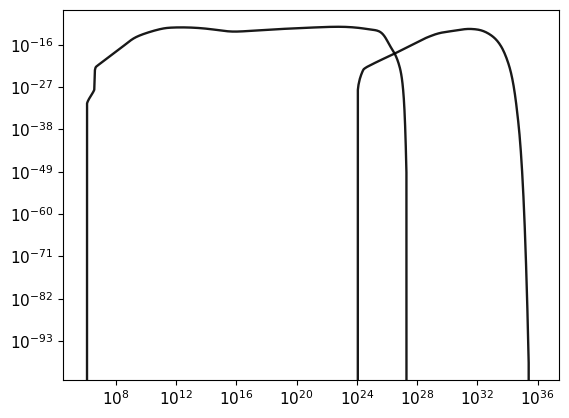

In [6]:

plt.loglog(total_x * ev_to_hz, total_y, ls='-',zorder=2000,
    lw=1.7,alpha=0.9,color='k')

# plt.loglog(total_x * ev_to_hz, total_syn, ls=':',zorder=2000,
#     lw=1.5,alpha=0.9,color='k')

plt.loglog(totalnu_x * ev_to_hz, totalnu_y / 3., ls='-',zorder=2000,
    lw=1.7,alpha=0.9,color='k')

roitr = (total_x>100e6) * ((total_x<100e9))
print(np.trapezoid(totalnu_y/totalnu_x, totalnu_x)/np.trapezoid(total_y[roitr]/total_x[roitr], total_x[roitr]))

/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_20949/2984751861.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[x<threshold] *= 0


(1e-15, 1e-10)

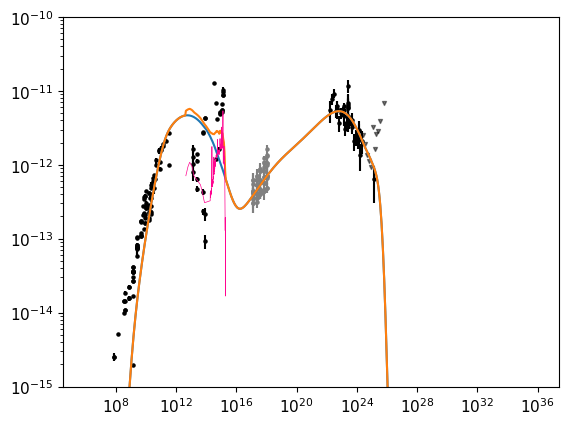

In [55]:
# Load the CSV file into a pandas DataFrame
data1 = pd.read_csv("/Users/xrodrigu/analysis/sin/sin-v/analysis/PKS_0605-08_mw_data.csv")  # Replace with the actual filename

# Convert 'Is Upper Limit' to boolean (optional but useful)
data1['Is Upper Limit'] = data1['Is Upper Limit'].astype(bool)


# 0605 DATA

dataran = ~((data1['Energy'] > 1e2) * (data1['Energy'] < 1e7))



x1 = data1['Energy'][dataran]
y1 = data1['Flux Value'][dataran]
e1 = data1['Flux Error'][dataran]
u1 = data1['Is Upper Limit'][dataran].astype(bool)


# FIRMAMENTO DATA

data2 = pd.read_csv("/Users/xrodrigu/Downloads/_5598929458_Sed.csv")

firran = (data2['freq. '] > 1e2*ev_to_hz) * (data2['freq. '] < 1e7*ev_to_hz)

plt.scatter(data1['Energy'][dataran][data1['Is Upper Limit'] == 0] * ev_to_hz,
            data1['Flux Value'][dataran][data1['Is Upper Limit'] == 0],
            s=5,c='k',
            alpha=1.0)

plt.scatter(data1['Energy'][dataran][data1['Is Upper Limit']] * ev_to_hz,
            data1['Flux Value'][dataran][data1['Is Upper Limit']],
            s=8,c='k',
            marker="v",
            alpha=0.5)

plt.errorbar(data1['Energy'][dataran][data1['Is Upper Limit'] == 0] * ev_to_hz,
            data1['Flux Value'][dataran][data1['Is Upper Limit'] == 0],
            data1['Flux Error'][dataran][data1['Is Upper Limit'] == 0],
            ls='none',
            color='k')

plt.scatter(data2['freq. '][firran][data2['flag'] == '  '],
            data2['flux '][firran][data2['flag'] == '  '],
            s=5,c='gray',
            alpha=1.0)

plt.scatter(data2['freq. '][firran][data2['flag'] == 'UL'],
            data2['flux '][firran][data2['flag'] == 'UL'],
            s=8,c='gray',
            marker="v",
            alpha=0.5)

plt.errorbar(data2['freq. '][firran][data2['flag'] == '  '],
            data2['flux '][firran][data2['flag'] == '  '],
            data2['err_flux '][firran][data2['flag'] == '  '],
            ls='none',
            color='gray',
            alpha=1.0)



all_x = np.concatenate([data1['Energy'][dataran][data1['Is Upper Limit']] * ev_to_hz,
                data1['Energy'][dataran][data1['Is Upper Limit'] == 0] * ev_to_hz,
                data2['freq. '][firran][data2['flag'] == 'UL'],
                data2['freq. '][firran][data2['flag'] == '  '],])
all_y = np.concatenate([data1['Flux Value'][dataran][data1['Is Upper Limit']],
                data1['Flux Value'][dataran][data1['Is Upper Limit'] == 0],
                data2['flux '][firran][data2['flag'] == 'UL'],
                data2['flux '][firran][data2['flag'] == '  '],])
all_e = np.concatenate([data1['Flux Value'][dataran][data1['Is Upper Limit']],
                data1['Flux Error'][dataran][data1['Is Upper Limit'] == 0],
                data2['flux '][firran][data2['flag'] == 'UL'],
                data2['err_flux '][firran][data2['flag'] == '  '],])

all_u = np.concatenate([data1['Flux Value'][dataran][data1['Is Upper Limit']]*0+1,
                data1['Flux Value'][dataran][data1['Is Upper Limit'] == 0]*0,
                data2['flux '][firran][data2['flag'] == 'UL']*0+1,
                data2['flux '][firran][data2['flag'] == '  ']*0])
all_u = np.bool(all_u)


gbb = get_blue_bump(PARAMS['z'], PARAMS['disk_lum'])
plt.loglog(gbb[0], gbb[1] / (4 * np.pi * (cosmo.luminosity_distance(PARAMS['z']).cgs.value) ** 2),
            zorder=1000,lw=0.5,
            color=sns.xkcd_rgb['electric pink'])

total_y_chi = total_y + np.interp(total_x*ev_to_hz, gbb[0], 
                                                    gbb[1] / (4 * np.pi * (cosmo.luminosity_distance(PARAMS['z']).cgs.value) ** 2),
                                                    left=1e-100, right=1e-100)

plt.loglog(total_x*ev_to_hz, total_y)

plt.loglog(total_x*ev_to_hz, total_y_chi)


plt.ylim([1e-15,1e-10])




6.36273610110672


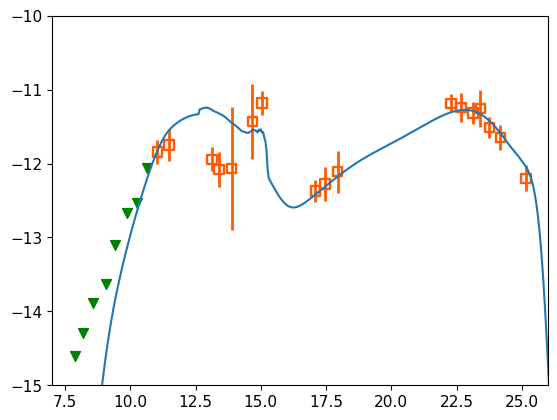

In [87]:
# plt.plot(np.log10(total_x*ev_to_hz), np.log10(total_y))
# plt.scatter(np.log10(all_x[~all_u]), np.log10(all_y[~all_u]),color='gray')
# plt.errorbar(np.log10(all_x[~all_u]), np.log10(all_y[~all_u]), np.log10(all_e[~all_u]),ls='',color='gray')
# plt.scatter(np.log10(all_x[all_u]), np.log10(all_y[all_u]),marker='v')
# plt.ylim([-15,-10])
# plt.xlim([1e9,1e15])

binned_x, binned_y, binned_err, binned_isuplim = bin_data(all_x, all_y, all_e, all_u)
binned_isuplim[binned_x<np.log10(1e11)] = True

plt.scatter(binned_x[~binned_isuplim] , binned_y[~binned_isuplim],
            facecolors='none',s=45,marker='s',edgecolor=sns.xkcd_rgb['bright orange'],lw=1.7)
plt.errorbar(binned_x[~binned_isuplim], binned_y[~binned_isuplim], binned_err[~binned_isuplim], 
                ls='none',color=sns.xkcd_rgb['bright orange'],elinewidth=2.0)

plt.scatter(binned_x[binned_isuplim], binned_y[binned_isuplim], marker='v',s=50,color='green')

plt.plot(np.log10(total_x*ev_to_hz), np.log10(total_y_chi))

plt.axis([7.0,26.0,-15,-10])

print(calc_chi2(binned_x, binned_y,  binned_err, binned_isuplim, 
                         np.log10(total_x*ev_to_hz), np.log10(total_y_chi), npars=11,verb=1))


In [45]:
binned_err

array([0.1       , 0.1       , 0.13643603, 0.65973362, 0.12579757,
       0.30602382, 0.2629023 , 0.25628174, 0.16511066, 0.21779145,
       0.1585953 , 0.23620829, 0.83580043, 0.51059465, 0.15804194,
       0.1541431 , 0.22544533, 0.28327627, 0.12247839, 0.19906129,
       0.15208694, 0.25016833, 0.14115348, 0.16884274, 0.17961292])

(np.float64(64.73634071024394), np.float64(216.0406345169731))

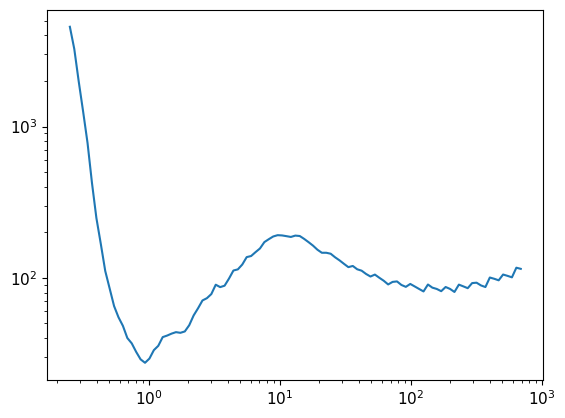

In [11]:
radvals = np.array([ra['radlum'] for ra in rate_arrays])
crlvals = np.array([ra['crlum'] for ra in rate_arrays])

plt.loglog(RDR_ARR, crlvals / radvals)

np.sum(crlvals) / np.sum(radvals), np.sum(crlvals / radvals) / crlvals.size

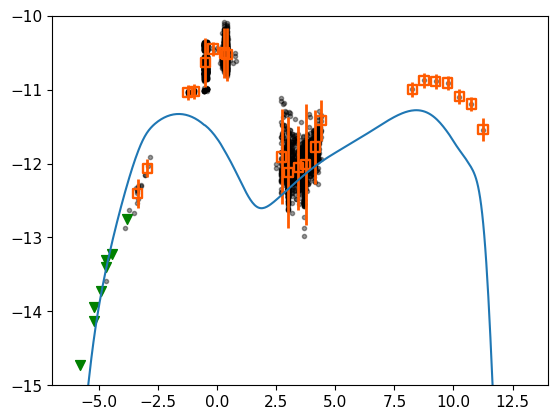

42.86544828297448


In [14]:
def bin_data(data_x, data_y, data_err, is_uplim, eps=0.4):
    
    x = np.log10(data_x[~is_uplim])
    bins = np.arange(np.min(x) - eps/2, np.max(x) + eps, eps)
    dig = np.digitize(x,bins)-1

    
    binned_x = np.array([np.mean(np.log10(data_x[~is_uplim])[(x >= bins[i]) * (x < bins[i] + eps)]) 
                         for i in set(dig)])
    binned_y = np.array([np.mean(np.log10(data_y[~is_uplim])[(x >= bins[i]) * (x < bins[i] + eps)]) 
                         for i in set(dig)])
    binned_e = np.log10(np.array([np.max(((data_err[~is_uplim]+data_y[~is_uplim])/data_y[~is_uplim])[(x >= bins[i]) * (x < bins[i] + eps)]) 
                                  for i in set(dig)]))
    binned_spread = np.array([np.ptp(np.log10(data_y[~is_uplim])[(x >= bins[i]) * (x < bins[i] + eps)]) 
                              for i in set(dig)])
    binned_spread *=0.5
    binned_spread = np.maximum(np.full(binned_spread.size,0.1), binned_spread)
    binned_err = np.maximum(binned_spread,binned_e)

    errrange = is_uplim * (data_x < 1e-3)
    binned_x = np.concatenate([binned_x,np.log10(data_x[errrange])])
    binned_y = np.concatenate([binned_y,np.log10(data_y[errrange])])
    binned_err = np.concatenate([binned_err,np.log10((data_err[errrange]+data_y[errrange])/data_y[errrange])])
    
    binned_isuplim = np.full(binned_err.size, False)
    binned_isuplim[binned_e.size:] += True
    
    srt = np.argsort(binned_x[np.isfinite(binned_x)])
    return binned_x[srt], binned_y[srt], binned_err[srt], binned_isuplim[srt]
    
def calc_chi2(xdata, ydata, yerrs, isuplim, xmod, ymod, npars=0,verb=0):
    """Calculate reduced chi2 values (lin and log) between data and model.
    """
    yerrs_nonzero = yerrs.copy()
    yerrs_nonzero[yerrs==0] = ydata[yerrs == 0] * .2
    
    yerrs_nonzero[yerrs<ydata*0.05] = ydata[yerrs<ydata*0.05] * .2
    
    yint = np.interp(xdata, 
                      xmod, 
                       ymod)
    roi = np.logical_not(isuplim * (yint <= ydata))
    chi2arr_lin = roi * (         ydata  -          yint ) ** 2 /          yerrs_nonzero  ** 2
    # chi2arr_log = roi * (np.log10(ydata) - np.log10(yint)) ** 2 / np.log10(yerrs_nonzero) ** 2
    chi2arr_lin[np.isinf(chi2arr_lin)] = 1e3
    # chi2arr_log[np.isinf(chi2arr_log)] = 1e3
    
    chi2arr_lin[np.isnan(chi2arr_lin)] = 1e3
    # chi2arr_log[np.isnan(chi2arr_log)] = 1e3

    chi2_lin = np.nansum(chi2arr_lin) / (np.sum(roi) - npars)
    # chi2_log = np.nansum(chi2arr_log) / (np.sum(roi) - npars)

    if verb and npars >= np.sum(roi):
        print("[calc_chi2]Warning: invalid chi2 test (#parameters >= #data points)")

    
    # ### DEBUG - PLOT
    # print(chi2arr_lin)
    # plt.plot(xmod, ymod)
    # plt.scatter(xdata[~isuplim], ydata[~isuplim],marker='.',color='k')
    # plt.scatter(xdata[isuplim], ydata[isuplim],marker='v',color='gray')
    # plt.axis([-7,15,-17,-9])
    # plt.show()
    # ###

    
    return chi2_lin




binned_x, binned_y, binned_err, binned_isuplim = bin_data(data_x, data_y, data_err, is_uplim)
binned_isuplim[binned_x<np.log10(1e11/ev_to_hz)] = True

xr = (binned_x >-3.6) * (binned_x < -3.1) 
plt.scatter(np.log10(data_x[~is_uplim]),np.log10(data_y[~is_uplim]), marker='.',c='k',alpha=0.4)
plt.scatter(np.log10(data_x[is_uplim]),np.log10(data_y[is_uplim]), marker='v',c='k',alpha=0.2)


plt.scatter(binned_x[~binned_isuplim] , binned_y[~binned_isuplim],
            facecolors='none',s=45,marker='s',edgecolor=sns.xkcd_rgb['bright orange'],lw=1.7)
plt.errorbar(binned_x[~binned_isuplim], binned_y[~binned_isuplim], binned_err[~binned_isuplim], 
                ls='none',color=sns.xkcd_rgb['bright orange'],elinewidth=2.0)

plt.scatter(binned_x[binned_isuplim], binned_y[binned_isuplim], marker='v',s=50,color='green')


# plt.scatter(binned_x , binned_y,
            # facecolors='none',s=300,marker='o' ,edgecolor=sns.xkcd_rgb['purple'],lw=1.7)

plt.plot(np.log10(total_x), np.log10(total_y))
plt.axis([-7,14,-15,-10])
plt.show()

print(calc_chi2(binned_x, binned_y,  binned_err, binned_isuplim, 
                         np.log10(total_x), np.log10(total_y), npars=11,verb=1))



/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:170: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = np.trapz(dens_dist_unnorm(np.logspace(np.log10(6e15),np.log10(R_BLR),100)), np.logspace(np.log10(6e15),np.log10(R_BLR),100))
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/719377682.py:238: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = np.trapz(dens_dist_unnorm(np.logspace(np.log10(6e15),np.log10(R_BLR),100)), np.logspace(np.log10(6e15),np.log10(R_BLR),100))


[model_klum_bhf]Error: some klum vals are negative: -1.8e+46. Increase initial Lorentz factor or decrease B evolution!
[model_lor]Warning: 22 negative L_kin vals ! Returning Gamma_bulk = 1  for those cases.


/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/3799455730.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lum_arr = np.array([np.trapz(ta[1] /  ta[0], ta[0]) for ta in total_arrays])
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/3799455730.py:74: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gamma_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]<=1e11)*(ta[0]>=1e8)], (ta[0])[(ta[0]<=1e11)*(ta[0]>=1e8)]) for ta in total_arrays])
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_1604/3799455730.py:75: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  x_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]<=100e3)*(ta[0]>=100)], (ta[0])[(ta[0]<=100e3)*(ta[0]>=100

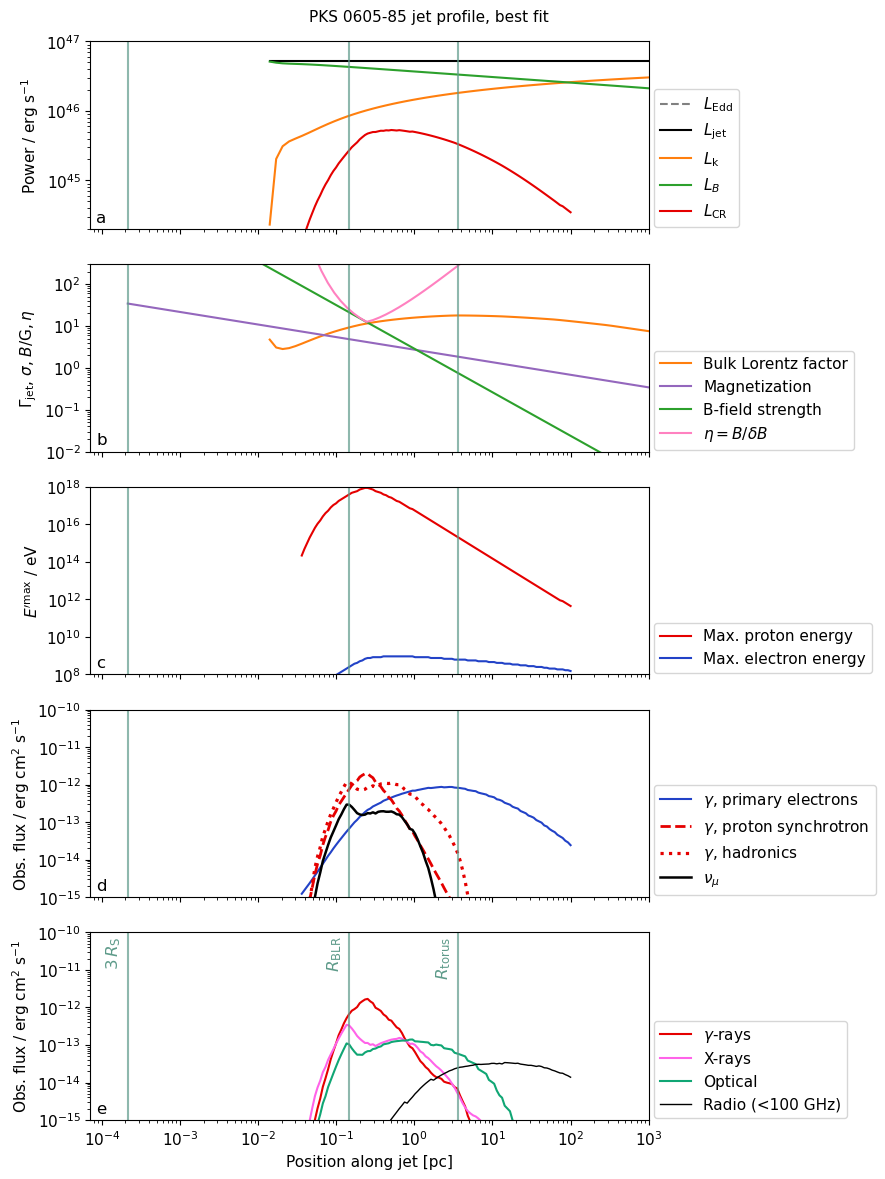

In [13]:
rarr2 = np.logspace(np.log10(3*schwarzschild(CAT[s]['M_BH'])),23,100) 
# rarr = np.logspace(np.log10(R_INIT), np.log10(RDR_ARR[-1] * R_BLR), 100)

lorarr = model_lor(rarr2)
magarr = model_magnetization(rarr2, lorarr)
barr = model_b(rarr2)
etarr = ETA_ACC(rarr2)
narr = model_n(rarr2,lorarr)
mperg = (const.m_p * const.c**2).to(u.erg).value

klarr = model_klum_bhf(rarr2, lorarr)
blarr = model_blum_bhf(rarr2, lorarr)


fig, axs = plt.subplots(5, 1, figsize=(9, 12), sharex=True)

plt.suptitle("PKS 0605-85 jet profile, best fit      ",y=0.98,fontsize=11)

ca = axs[0]
# Power
ca.hlines([eddington_lum(CAT[s]['M_BH'])], schwarzschild(CAT[s]['M_BH']), rarr2[-1], color='gray', ls='--', label=r'$L_\mathrm{Edd}$')
ca.loglog(rarr2 * u.cm.to(u.pc), blarr + klarr, c='k', label=r'$L_\mathrm{jet}$')
ca.loglog(rarr2 * u.cm.to(u.pc), klarr, label=r'$L_\mathrm{k}$', c='tab:orange')
ca.loglog(rarr2 * u.cm.to(u.pc), blarr, label=r'$L_B$', c='tab:green')
ca.loglog(r_arr, [ra['lor'] ** 2 * ra['crlum'] for ra in rate_arrays], c=sns.xkcd_rgb['red'], label=r'$L_\mathrm{CR}$')
ca.set_ylabel(r'Power / erg s$^{-1}$')
ca.legend(loc=(1.01,0.01))
ca.set_ylim([2e44,1e47])

# Lorentz factor
ca = axs[1]
ca.loglog(rarr2 * u.cm.to(u.pc), lorarr, c='tab:orange', label='Bulk Lorentz factor')
ca.loglog(rarr2 * u.cm.to(u.pc), magarr, c='tab:purple', label='Magnetization')
ca.loglog(rarr2 * u.cm.to(u.pc), barr, c='tab:green', label='B-field strength')
ca.loglog(rarr2 * u.cm.to(u.pc), etarr, c=sns.xkcd_rgb['pink'], label=r'$\eta=B/\delta B$')

ca.set_ylabel(r'$\Gamma_\mathrm{jet}$, $\sigma$, $B/\mathrm{G}, \eta$')
ca.legend(loc=(1.01,0.01))
ca.set_ylim([1e-2,300])


# ca = axs[2]
# radarr = model_rblob(rarr2, lorarr)
# # Power
# ca.loglog(rarr2, radarr, c=sns.xkcd_rgb['magenta'], label=r'$R^\prime_\mathrm{jet}$')
# ca.set_ylabel(r'$R^\prime_\mathrm{j}$ / cm')
# ca.legend(loc=(1.01,0.01))
# # ca.set_ylim([1e13,1e18])



ca = axs[2]
# Maximum energy
ca.loglog(r_arr, [ra['emax_p'] for ra in rate_arrays], c=sns.xkcd_rgb['red'], label=r'Max. proton energy')
ca.loglog(r_arr, [ra['emax_e'] for ra in rate_arrays], c=sns.xkcd_rgb['blue blue'], label=r'Max. electron energy')
ca.set_ylabel(r'$E^{\prime\mathrm{max}}$ / eV')
ca.legend(loc=(1.01,0.01))
ca.set_ylim([1e8,1e18])

# Luminosity distribution
ca = axs[3]
ca.loglog(r_arr, elum_arr, c=sns.xkcd_rgb['blue blue'], label=r'$\gamma$, primary electrons')
# ca.loglog(r_arr, plum_arr, c='tab:red', label='Protons')
ca.loglog(r_arr, pslum_arr, c=sns.xkcd_rgb['red'], ls='--',lw=2, label=r'$\gamma$, proton synchrotron')
ca.loglog(r_arr, pplum_arr+bhlum_arr+bhlum_arr, c=sns.xkcd_rgb['red'],lw=2.3,ls=':', label=r'$\gamma$, hadronics')
ca.loglog(r_arr, nulum_arr, c='k',lw=1.8,ls='-', label=r'$\nu_\mu$')
ca.set_ylabel('Obs. flux / erg cm$^2$ s$^{-1}$')
# ca.set_xlabel('Position along jet [pc]')
ca.legend(loc=(1.01,0.01))
ca.set_ylim([1e-15,1e-10])


lum_arr = np.array([np.trapz(ta[1] /  ta[0], ta[0]) for ta in total_arrays])
gamma_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]<=1e11)*(ta[0]>=1e8)], (ta[0])[(ta[0]<=1e11)*(ta[0]>=1e8)]) for ta in total_arrays])
x_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]<=100e3)*(ta[0]>=100)], (ta[0])[(ta[0]<=100e3)*(ta[0]>=100)]) for ta in total_arrays])
optical_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]*ev_to_hz<=(1e16))*(ta[0]*ev_to_hz>=1e14)], (ta[0])[(ta[0]*ev_to_hz<=(1e16))*(ta[0]*ev_to_hz>=1e14)]) for ta in total_arrays])
radio_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]<=1e-1)], (ta[0])[(ta[0]<=1e-1)]) for ta in total_arrays])
tenghz_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]*ev_to_hz<=10e9)], (ta[0])[(ta[0]*ev_to_hz<=10e9)]) for ta in total_arrays])
hunghz_arr = np.array([np.trapz((ta[1] * ta[2] /  ta[0])[(ta[0]*ev_to_hz<=100e9)], (ta[0])[(ta[0]*ev_to_hz<=100e9)]) for ta in total_arrays])


# Energy distribution
ca = axs[4]
ca.loglog(r_arr, gamma_arr, c=sns.xkcd_rgb['red'], lw=1.5,label=r'$\gamma$-rays')
ca.loglog(r_arr, x_arr, c=sns.xkcd_rgb['candy pink'], lw=1.5,label=r'X-rays')
ca.loglog(r_arr, optical_arr, c=sns.xkcd_rgb['bluish green'],lw=1.5, label='Optical')
ca.loglog(r_arr, hunghz_arr, c='k',lw=1.0, label='Radio (<100 GHz)')
ca.set_ylabel('Obs. flux / erg cm$^2$ s$^{-1}$')
ca.set_xlabel('Position along jet [pc]')
ca.legend(loc=(1.01,0.01))
ca.set_ylim([1e-15,1e-10])

ca.text(0.86 * 3*schwarzschild(CAT[s]['M_BH']) * u.cm.to(u.pc),8e-11, r"$3\,R_\mathrm{S}$",rotation=90, verticalalignment='top', horizontalalignment='right',color=sns.xkcd_rgb['grey teal'],fontsize=12)
ca.text(0.86 * R_BLR * u.cm.to(u.pc),8e-11, r"$R_\mathrm{BLR}$",rotation=90, verticalalignment='top', horizontalalignment='right',color=sns.xkcd_rgb['grey teal'],fontsize=12)
ca.text(0.86 * R_TORUS * u.cm.to(u.pc),8e-11, r"$R_\mathrm{torus}$",rotation=90, verticalalignment='top', horizontalalignment='right',color=sns.xkcd_rgb['grey teal'],fontsize=12)

for ca, label in zip(axs, ['a', 'b', 'c', 'd', 'e']):
    ca.vlines([3*schwarzschild(CAT[s]['M_BH'])*u.cm.to(u.pc), R_BLR*u.cm.to(u.pc), R_TORUS*u.cm.to(u.pc)],1e-100,1e100,color=sns.xkcd_rgb['grey teal'],alpha=0.7)
    # ca.fill_between([1e-10,R_BLR*u.cm.to(u.pc)],[1e-100,1e-100], [1e100,1e100],color=sns.xkcd_rgb['grey teal'],alpha=0.05)
    # ca.fill_between([schwarzschild(CAT[s]['M_BH'])*u.cm.to(u.pc),3*schwarzschild(CAT[s]['M_BH'])*u.cm.to(u.pc)],[1e-100,1e-100], [1e100,1e100],color=sns.xkcd_rgb['grey teal'],alpha=0.15)
    ca.text(0.01, 0.02, label, transform=ca.transAxes, fontsize=12, verticalalignment='bottom')



plt.xlim([schwarzschild(CAT[s]['M_BH'])*u.cm.to(u.pc), 1e3])

plt.subplots_adjust(hspace=0.1)
# Adjust layout
plt.tight_layout()

plt.savefig(f'plots/parameter_evolution_PKS_0605-85.png', dpi=300)
plt.show()


In [14]:
np.savez("plotdata_PKS0605.npz",
    rarr2=rarr2,                        # cm
    lorarr=lorarr,
    magarr=magarr,
    barr=barr,
    etarr=etarr,
    klarr=klarr,
    blarr=blarr,
    r_arr=r_arr,                        # cm
    lcr_arr=[ra['lor']**2 * ra['crlum'] for ra in rate_arrays],
    emax_p=[ra['emax_p'] for ra in rate_arrays],
    emax_e=[ra['emax_e'] for ra in rate_arrays],
    elum_arr=elum_arr,
    pslum_arr=pslum_arr,
    pplum_arr=pplum_arr,
    bhlum_arr=bhlum_arr,
    nulum_arr=nulum_arr,
    gamma_arr=gamma_arr,
    x_arr=x_arr,
    optical_arr=optical_arr,
    hunghz_arr=hunghz_arr,
    M_BH=CAT[s]['M_BH'],               # float in Msun
    R_BLR=R_BLR,                       # cm
    R_TORUS=R_TORUS                    # cm
)


In [31]:
tst = np.load("plots/hsp_sed_arrays.npy", allow_pickle=True)
print(tst[0])


np.save("plots/hsp_sed_arrays_clean.npy", sed_arrays, allow_pickle=True)

{'x_lep': array([5.10998213e+05, 5.64740364e+05, 6.24134627e+05, 6.89775438e+05,
       7.62319755e+05, 8.42493623e+05, 9.31099451e+05, 1.02902403e+06,
       1.13724744e+06, 1.25685279e+06, 1.38903716e+06, 1.53512347e+06,
       1.69657381e+06, 1.87500404e+06, 2.07219994e+06, 2.29013511e+06,
       2.53099072e+06, 2.79717733e+06, 3.09135904e+06, 3.41648011e+06,
       3.77579446e+06, 4.17289823e+06, 4.61176577e+06, 5.09678941e+06,
       5.63282343e+06, 6.22523264e+06, 6.87994608e+06, 7.60351632e+06,
       8.40318511e+06, 9.28695581e+06, 1.02636735e+07, 1.13431134e+07,
       1.25360791e+07, 1.38545100e+07, 1.53116016e+07, 1.69219368e+07,
       1.87016324e+07, 2.06685002e+07, 2.28422254e+07, 2.52445632e+07,
       2.78995571e+07, 3.08337791e+07, 3.40765960e+07, 3.76604629e+07,
       4.16212483e+07, 4.59985932e+07, 5.08363075e+07, 5.61828086e+07,
       6.20916062e+07, 6.86218374e+07, 7.58388591e+07, 8.38149015e+07,
       9.26297917e+07, 1.02371752e+08, 1.13138283e+08, 1.25037140e+